# Sunshine Duration Forecasting using State-of-the-Art Deep Learning Models and ML Tools

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os

# change current working directory
os.chdir('/content/gdrive/My Drive/MRP/')

Mounted at /content/gdrive


In [2]:
# Create Directories
DIR_DATA = 'data/'
DIR_RAW = f'{DIR_DATA}raw_data/'
DIR_PROCESSED = f'{DIR_DATA}processed_data/'
DIR_FIGURES_EDA = 'eda_figures/'
DIR_RESULTS = 'results/'

for path in [DIR_RAW, DIR_PROCESSED, DIR_FIGURES_EDA, DIR_RESULTS]:

    if not os.path.exists(path):
            os.makedirs(path)

    if path == DIR_RESULTS:

        p_clean_experiments = f'{path}clean_experiments/'
        p_outlier_experiments = f'{path}outlier_experiments/'

        DIR_RESULTS_FIGURES_CLEAN = f'{p_clean_experiments}figures/'
        DIR_RESULTS_FIGURES_OUTLIERS = f'{p_outlier_experiments}figures/'
        DIR_HYPERPARAMS_CLEAN = f'{p_clean_experiments}hyperparam_tuning/'
        DIR_HYPERPARAMS_OUTLIERS= f'{p_outlier_experiments}hyperparam_tuning/'
        DIR_TRIALS_CLEAN = f'{DIR_HYPERPARAMS_CLEAN}trials/'
        DIR_TRIALS_OUTLIERS = f'{DIR_HYPERPARAMS_OUTLIERS}trials/'
        DIR_TRIALS_FIGS_CLEAN = f'{DIR_HYPERPARAMS_CLEAN}figures/'
        DIR_TRIALS_FIGS_OUTLIERS = f'{DIR_HYPERPARAMS_OUTLIERS}figures/'
        DIR_MODEL_RESULTS_CLEAN = f'{p_clean_experiments}model_results/'
        DIR_MODEL_RESULTS_OUTLIERS = f'{p_outlier_experiments}model_results/'
        DIR_MODELS_CLEAN = f'{p_clean_experiments}models/'
        DIR_MODELS_OUTLIERS = f'{p_outlier_experiments}models/'

        directories = [DIR_RESULTS_FIGURES_CLEAN, DIR_RESULTS_FIGURES_OUTLIERS,
                       DIR_HYPERPARAMS_CLEAN, DIR_HYPERPARAMS_OUTLIERS,
                       DIR_TRIALS_CLEAN, DIR_TRIALS_OUTLIERS,
                       DIR_TRIALS_FIGS_CLEAN, DIR_TRIALS_FIGS_OUTLIERS,
                       DIR_MODEL_RESULTS_CLEAN, DIR_MODEL_RESULTS_OUTLIERS,
                       DIR_MODELS_CLEAN, DIR_MODELS_OUTLIERS]

        for p in directories:
            if not os.path.exists(p):
                os.makedirs(p)

In [ ]:
!pip install -U optuna
!pip install optuna-integration
!pip install 'u8darts[all]'
!pip install kaleido==0.2.1

In [4]:
import warnings
warnings.filterwarnings("ignore")

import copy
import datetime
import importlib
import logging
logging.disable(logging.CRITICAL)
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.graph_objs as go
import random
import requests
import seaborn as sns
import sys
import time
import torch

from darts import concatenate
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse
from darts.models import RandomForest # for preliminary experiment; all other model calls are handled in the processing_functions.py module
from darts.models.forecasting.baselines import NaiveDrift, NaiveSeasonal, NaiveMean, NaiveMovingAverage
from darts.utils.callbacks import TFMProgressBar
from darts.utils.utils import SeasonalityMode
from datetime import datetime as dt
from project_code import processing_functions as pf, visualization_functions as vf, hyperparam_search as hp
from sklearn.preprocessing import MinMaxScaler


## Data Acquisition

The data for this project is sourced through Open-Meteo's free Historical Weather API, which does not require a developer key for access. It is collected for a geolocation that corresponds to Bordj Badji Mokhtar in Algeria.

### Selections for Data Download

**General Details:**

- Data Source: https://open-meteo.com/en/docs/historical-weather-api

**Bordj Badji Mokhtar (BBM) Details:**

- **Latitude:** 21.3292
- **Longitude:** 0.94791
- **Timezone:** Virtual Private Network (VPN) settings were set to 'DZ' (Algeria) and Timezone to 'Automatically detect time zone' because Central European Standard Time (GMT +1) or equivalent is not readily available as an option
- **Start Date:** 1994-01-01
- **End Date:** 2023-12-31

**Hourly Weather Variables:**
- **Temperature (2 m)**
- **Relative Humidity (2 m)**

**Additional Variables:**
- **Sunshine Duration**

Although Daily Weather Variables are directly available, Relative Humidity information is only available under Hourly Variables, so the data is procured at that level of granularity. Additionally, information is collected from 1995 onwards so that there is a large enough dataset for deep learning purposes, but only 2002 to 2006 will be used for the El-kenawy et al. comparison analysis.

**Settings:**

- **Temperature Unit:** Celsius  
- **Wind Speed Unit:** Km/h  
- **Precipitation Unit:** Millimeter  
- **Timeformat:** ISO 8601 (e.g. 2022-12-31)


**API Call/Link:**

- https://archive-api.open-meteo.com/v1/era5?latitude=21.3292&longitude=0.94791&start_date=1994-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,sunshine_duration&timezone=auto

Per the documentation, we specify 'era5' in the API call in order to get data from the ERA5 reanalysis model, thereby ensuring data consistency, and preventing the capture of unintentional alterations that may have arisen from the adoption of different weather model upgrades.



In [ ]:
# Download data from Open Meteo
file_name = 'era5_data_BordjBadjiMokhtar.json'
api_call = 'https://archive-api.open-meteo.com/v1/era5?latitude=21.3292&longitude=0.94791&start_date=1994-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,sunshine_duration&timezone=auto'
pf.download_data(api_call, DIR_RAW, file_name)

Data successfully downloaded to data/raw_data/era5_data_BordjBadjiMokhtar.json.


In [ ]:
# read in data
file = f'{DIR_RAW}{file_name}'
data_bbm = pf.df_from_json(file)
data_bbm.name = 'Bordj Badji Mokhtar Open Meteo Data - Hourly'
pf.generate_df_summary(data_bbm, name=True)

Dataframe: Bordj Badji Mokhtar Open Meteo Data - Hourly

------ Head: ------


,time,temperature_2m,relative_humidity_2m,sunshine_duration
0,1994-01-01T00:00,12.4,34,0.0
1,1994-01-01T01:00,11.4,36,0.0
2,1994-01-01T02:00,10.5,37,0.0
3,1994-01-01T03:00,9.7,37,0.0
4,1994-01-01T04:00,8.9,37,0.0




------ Tail: ------


,time,temperature_2m,relative_humidity_2m,sunshine_duration
262963,2023-12-31T19:00,24.4,11,0.0
262964,2023-12-31T20:00,21.5,13,0.0
262965,2023-12-31T21:00,20.4,13,0.0
262966,2023-12-31T22:00,19.3,13,0.0
262967,2023-12-31T23:00,18.0,14,0.0




------ Column Summaries: ------


,count,unique,top,freq
time,262968,262968,1994-01-01T00:00,1


,count,mean,std,min,25%,50%,75%,max
temperature_2m,262968.0,28.040200,9.081526,1.4,21.3,28.8,35.2,46.9
relative_humidity_2m,262968.0,18.812570,11.562204,2.0,11.0,16.0,24.0,99.0
sunshine_duration,262968.0,1623.146004,1761.774532,0.0,0.0,0.0,3600.0,3600.0




------ Counts: ------

Rows: 262,968
Columns: 4
Duplicate Rows = 0 | % of Total Rows = 0.0%


------ Info: ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262968 entries, 0 to 262967
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time                  262968 non-null  object 
 1   temperature_2m        262968 non-null  float64
 2   relative_humidity_2m  262968 non-null  int64  
 3   sunshine_duration     262968 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 8.0+ MB


None



------ Missing Data Percentage: ------


,0
time,0.0
temperature_2m,0.0
relative_humidity_2m,0.0
sunshine_duration,0.0


Based on a preliminary assessment, there is no duplicate or missing data present.



## Exploratory Daata Analysis

In [ ]:
df_daily = pf.daily_aggregations(data_bbm)
df_daily.name = 'Bordj Badji Mokhtar - Daily Aggregations'
df_daily.head(3)

,sunshine_hr,humidity_mean,temp_min,temp_mean,temp_max,temp_range
date,,,,,,
1994-01-01,10.0,29.833333,5.9,13.366667,20.8,14.9
1994-01-02,10.0,31.666667,3.2,12.654167,21.1,17.9
1994-01-03,10.0,23.958333,5.7,15.166667,24.3,18.6


In [ ]:
pf.generate_df_summary(df_daily, describe_only=True, name=True)

Dataframe: Bordj Badji Mokhtar - Daily Aggregations

------ Column Summaries: ------


,count,mean,std,min,25%,50%,75%,max
sunshine_hr,10957.0,10.820973,1.250392,0.000000,10.110119,10.817328,11.918311,12.084744
humidity_mean,10957.0,18.812570,8.893567,3.291667,12.541667,17.083333,23.083333,85.708333
temp_min,10957.0,20.045587,7.583512,1.400000,13.400000,21.100000,26.900000,34.800000
temp_mean,10957.0,28.040200,7.480956,7.554167,21.275000,29.658333,35.033333,41.045833
temp_max,10957.0,34.975997,7.170943,13.100000,28.800000,36.700000,41.400000,46.900000
temp_range,10957.0,14.930410,2.650838,3.500000,13.200000,15.000000,16.800000,24.300000


Sunshine duration (SD) ranges from 0h to 12h, while the temperature ranges from 1.4C to 46.9C; the latter range is derived from the minimum value of the temp_min column and the maximum value of the max_temp column. The widest temperature range on any given day is 24.3C.

Correlations



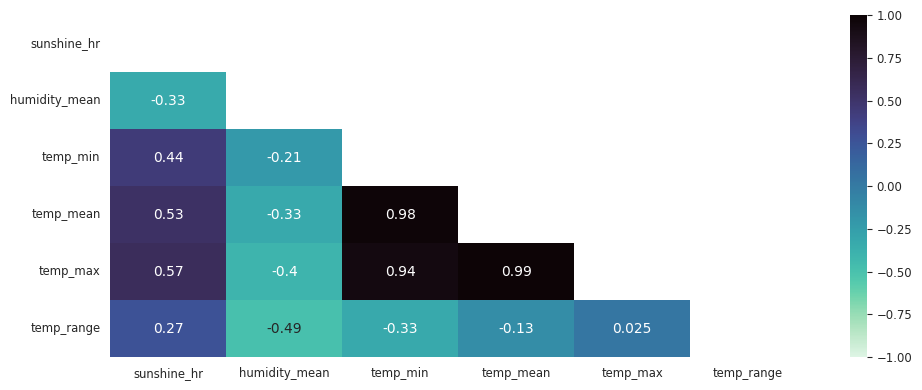

In [ ]:
sns.set_style("white")
print('Correlations\n')
vf.correlation_matrix(df_daily, figsize=(10,4), cmap='mako_r', name='correlations')

Maximum (0.57) and mean (0.53) temperature values are most strongly correlated with SD. However, these values indicate a generally moderate relationship. Mean humidity has a weak negative correlation with SD, at -0.33.

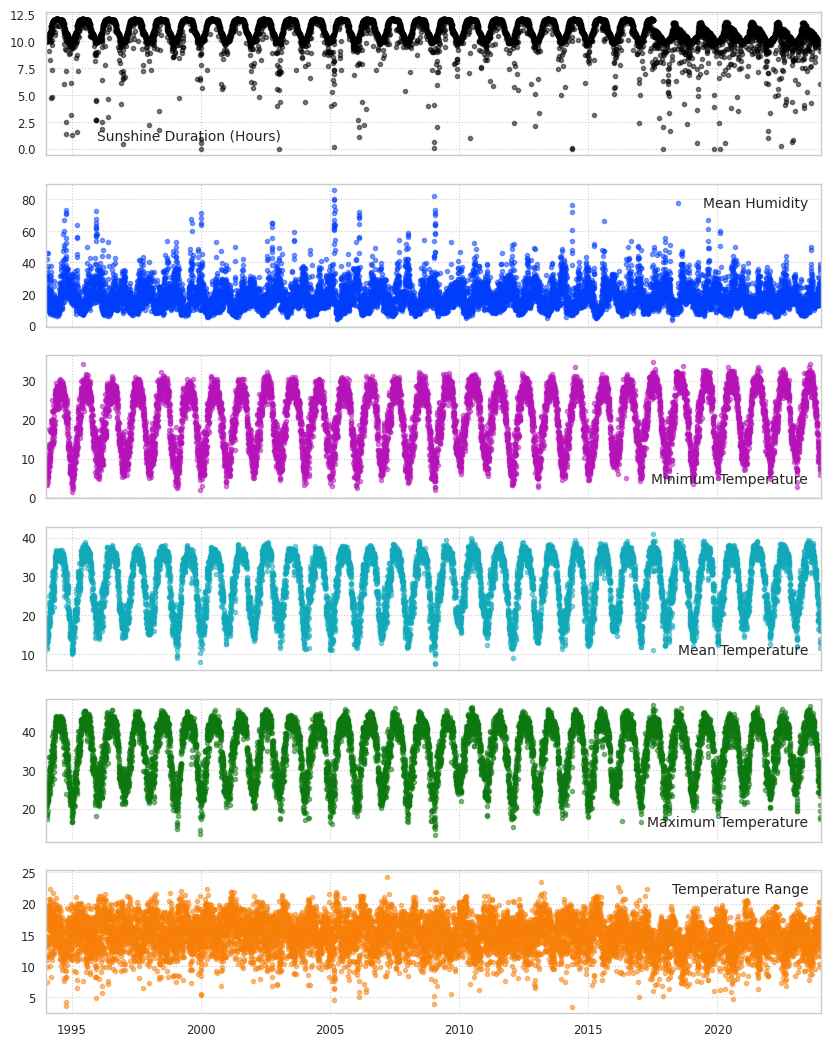

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})

# cols = ['sunshine_hr', 'temp_max', 'temp_range', 'humidity_mean']
df_daily.rename(columns={'sunshine_hr': 'Sunshine Duration (Hours)',
                        'temp_max': 'Maximum Temperature',
                        'temp_mean': 'Mean Temperature',
                        'temp_min': 'Minimum Temperature',
                        'temp_range': 'Temperature Range',
                        'humidity_mean': 'Mean Humidity'})\
                        .plot(marker='.',
                            alpha=0.5,
                            linestyle='None',
                            figsize=(10, 13),
                            subplots=True)
plt.xlabel('')
plt.show()

Sunshine Duration and Temperature exhibit a very clear annual seasonal pattern. There appears to have been a change in the shape of SD's pattern since ~2017, particularly with regards to its peak.


**Zeroing in on Sunshine Duration via decomposition:**

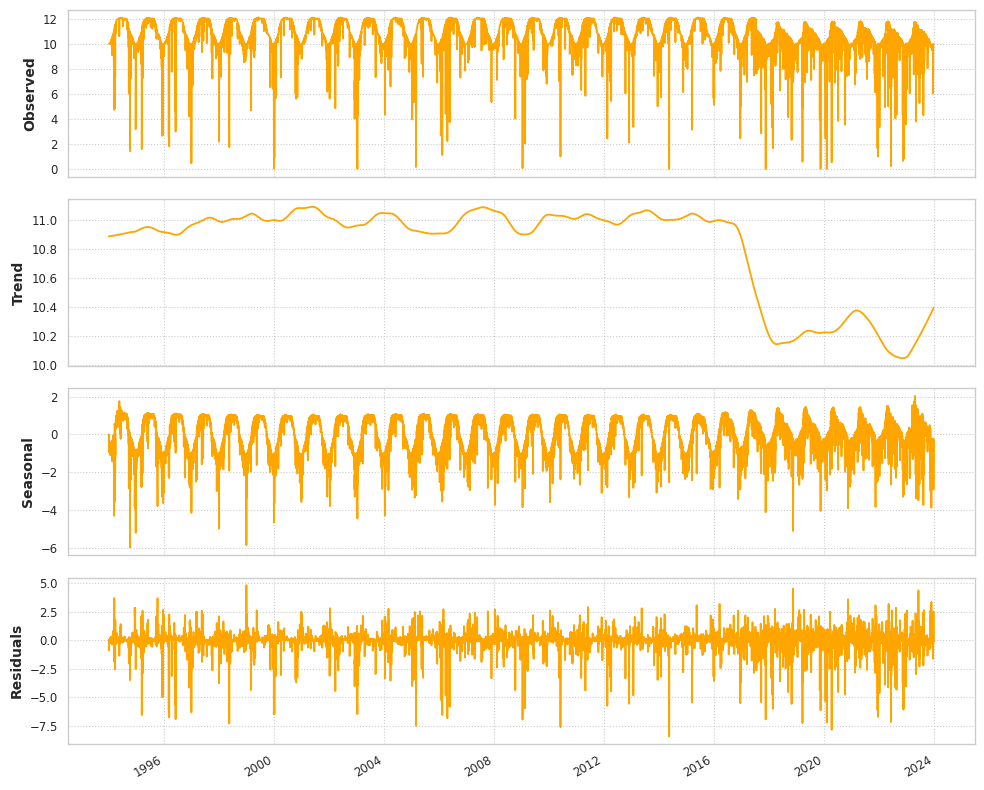

In [ ]:
vf.plot_seasonal_decomposition(df_daily, column='sunshine_hr', period=365, color='orange',
                               name='seasonal_decomposition')

Looking at the Trend chart, there is a sharp dip circa 2017 that had yet to have fully rebounded by the end of 2023; this has had a visible impact on the Residuals.

Bordj Badji Mokhtar Hourly Sunshine Duration (1995-2023)



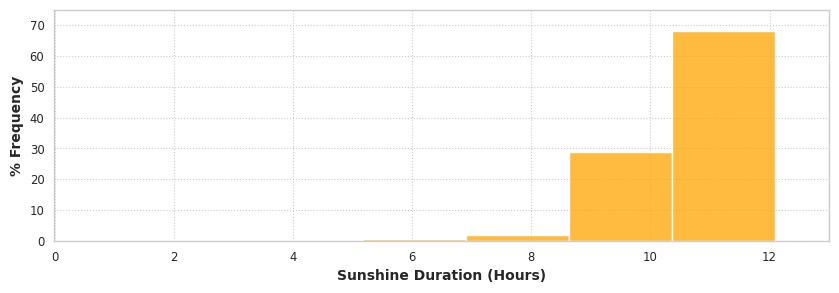

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})
plt.figure(figsize=(10,3))
sns.histplot(df_daily, x='sunshine_hr', bins=7, color='orange',
            stat='percent')
# plt.title('Bordj Badji Mokhtar Hourly Sunshine Duration (1995-2023)')
print('Bordj Badji Mokhtar Hourly Sunshine Duration (1995-2023)\n')
plt.xlabel('Sunshine Duration (Hours)')
plt.ylabel('% Frequency')
plt.xlim(-0.01, 13)
plt.ylim(0,75)
plt.grid(True)
plt.savefig(f'{DIR_FIGURES_EDA}hourly_sd_frequency.png')
plt.show()

In [ ]:
data_len = len(df_daily)
prop_bw_102_12 = len(df_daily[(df_daily['sunshine_hr'] >= 10.2) & (df_daily['sunshine_hr'] <=12.08)]) / data_len
prop_less_than_3 = len(df_daily[df_daily['sunshine_hr'] <= 8.5]) / data_len

print(f'{prop_bw_102_12:.1%} of the observed sunshine duration is between 10.2h\
 and 12h, and {prop_less_than_3:.1%} is below 8.5h')

72.2% of the observed sunshine duration is between 10.2h and 12h, and 2.9% is below 8.5h


In [ ]:
# Time-based variables for monthly and annual stats
df_daily['year'] = df_daily.index.year
df_daily['month'] = df_daily.index.month
df_daily['day_of_year'] = df_daily.index.day_of_year


month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
               'September', 'October', 'November', 'December']

month_label_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
               'Sep', 'Oct', 'Nov', 'Dec']

annual_monthly_means = df_daily.loc[:, ['sunshine_hr','year', 'month']].groupby(['year','month']).mean().reset_index()
daily_means = df_daily.loc[:, ['sunshine_hr','day_of_year']].groupby('day_of_year').mean().reset_index()

monthly_subset_means = {}

num_yrs_rolling_avg = 7

for idx, month in enumerate(month_labels):
    monthly_data = annual_monthly_means[annual_monthly_means['month'] == idx+1]
    monthly_data[f'{num_yrs_rolling_avg}yr_rolling_avg'] = monthly_data.sunshine_hr.rolling(num_yrs_rolling_avg).mean()
    monthly_subset_means[month] = monthly_data

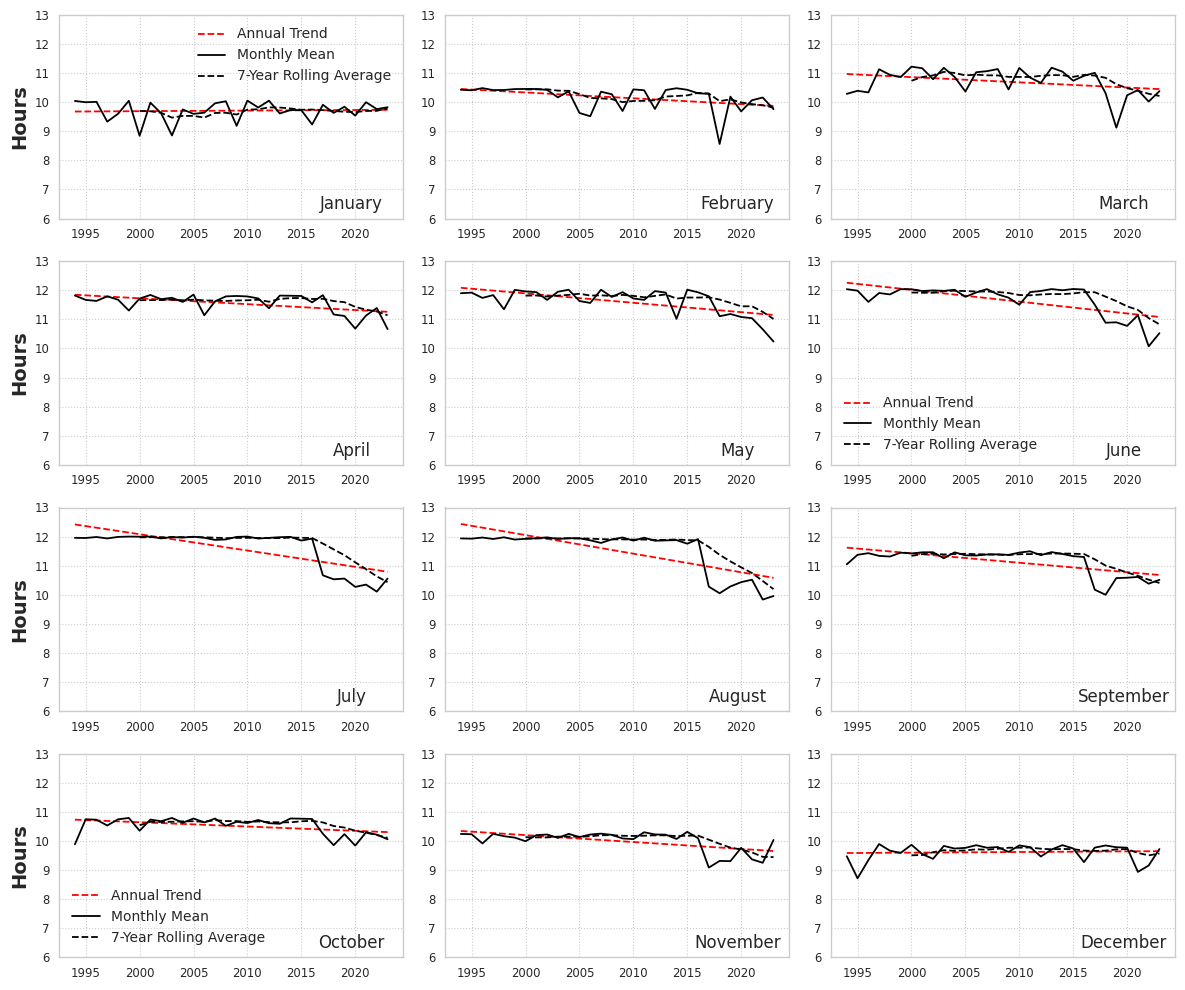

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})
vf.plot_monthly_charts(monthly_data=monthly_subset_means, num_yrs_rolling_avg=num_yrs_rolling_avg,
                        column='sunshine_hr', figsize=(12, 10),
                        x_label='', x_font_size=12,
                        y_label='Hours',  y_font_size=14,
                        ylim_start=6, name='monthly_sunshine_trends')


There has been a downward annual trend for most of the months, and the steepest ones can be seen in June through August, with the accompanying sharp downward slope for the 7-year rolling average. The now-familiar ~2017 dip can be observed across numerous months. There have been year-over-year fluctuations in December and January, but the annual trend for these months is relatively flat.

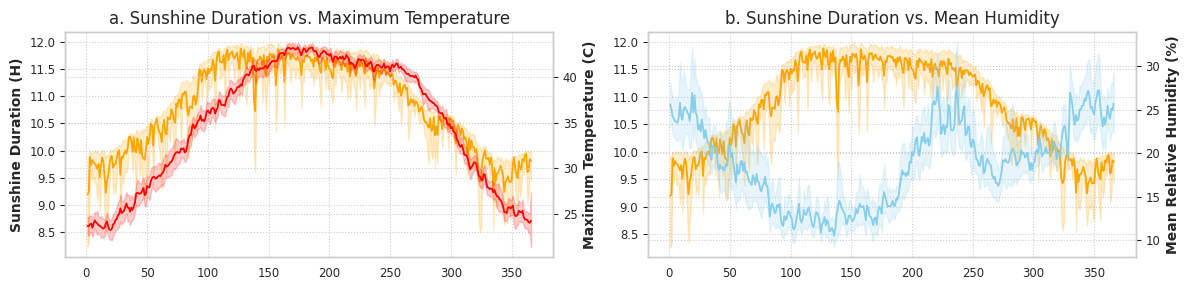

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
# fig.suptitle('Monthly Total Sunshine Duration', size=15)
sunshine_hr = 'sunshine_hr'
day_of_year = 'day_of_year'

# Plot Daily Sunshine Duration vs. Max Temperature and Relative Humidity
sns.lineplot(ax=axes[0], data=df_daily, x=day_of_year, y=sunshine_hr, color='orange')
axes[0].set_ylabel('Sunshine Duration (H)')
axes[0].set_xlabel('')
axes[0].set_title('a. Sunshine Duration vs. Maximum Temperature')
ax2 = axes[0].twinx()
sns.lineplot(ax=ax2, data=df_daily, x=day_of_year, y='temp_max', color='r')
ax2.set_ylabel('Maximum Temperature (C)')

sns.lineplot(ax=axes[1], data=df_daily, x=day_of_year, y=sunshine_hr, color='orange')
axes[1].set_title('b. Sunshine Duration vs. Mean Humidity')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
ax4 = axes[1].twinx()
sns.lineplot(ax=ax4, data=df_daily, x=day_of_year, y='humidity_mean', color='skyblue')
ax4.set_ylabel('Mean Relative Humidity (%)')

fig.tight_layout()
plt.savefig(f'{DIR_FIGURES_EDA}daily_trends.png')

Maximum Temperature and Sunshine Duration generally follow the same trend and maintain their relationship throughout most of the year. Relative Mean Humidity, on the other hand, displays a pronounced inverse relationship with SD during various parts of the year.

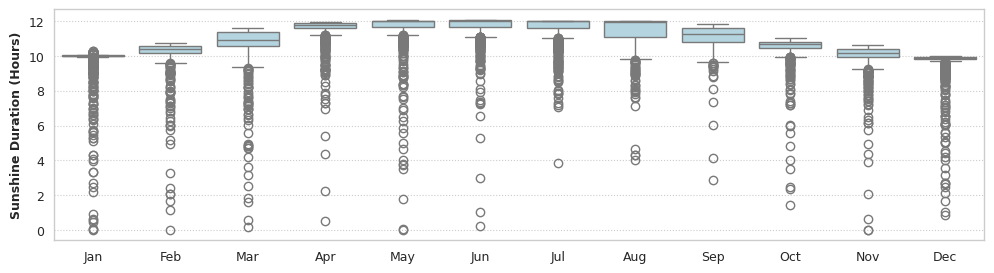

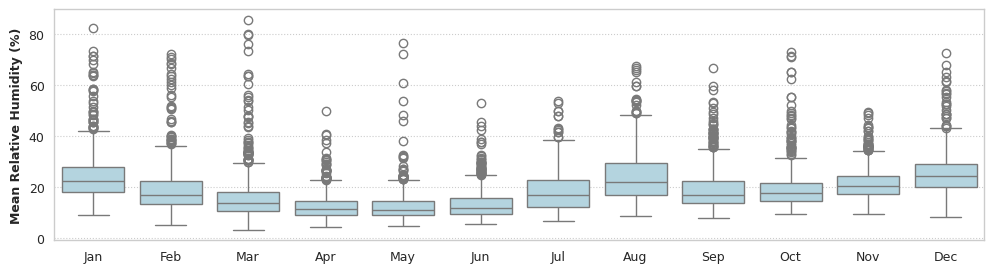

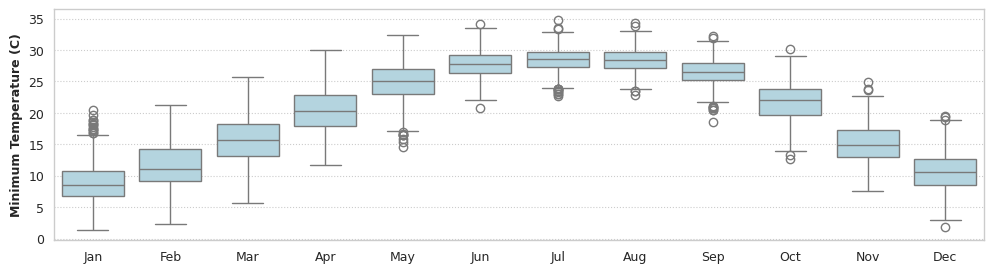

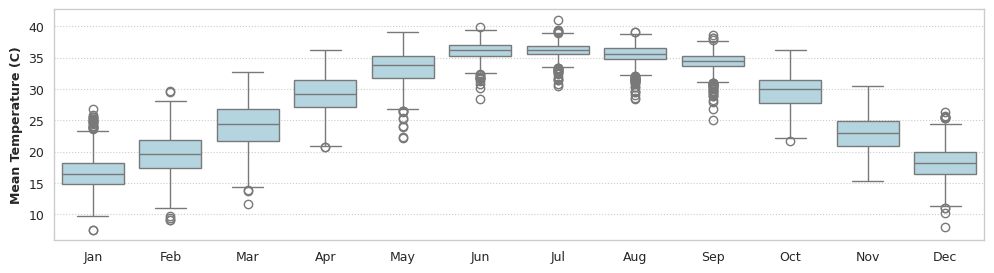

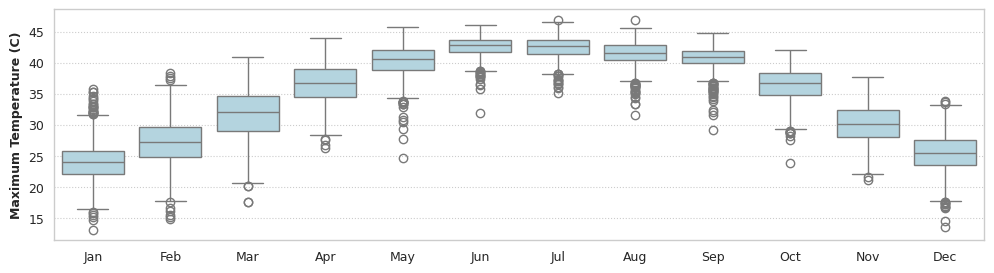

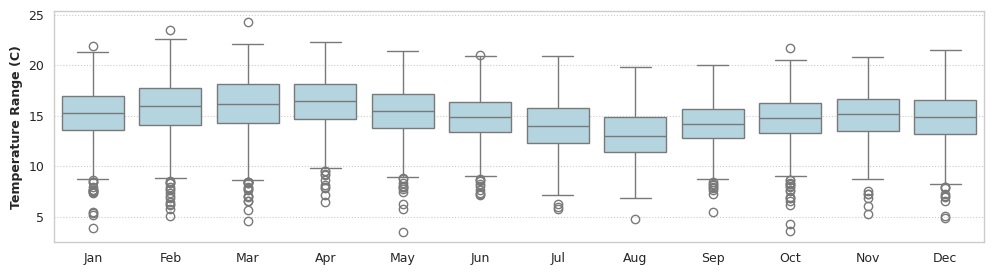

In [ ]:
# Outlier Assessment

y_labels = {
    'sunshine_hr': 'Sunshine Duration (Hours)',
    'temp_min': 'Minimum Temperature (C)',
    'temp_mean': 'Mean Temperature (C)',
    'temp_max': 'Maximum Temperature (C)',
    'temp_range': 'Temperature Range (C)',
    'humidity_mean': 'Mean Relative Humidity (%)',
}

cols_to_plot = df_daily.columns[:-3]

vf.generate_boxplots(data=df_daily, columns=cols_to_plot, granularity='month',
                     alternate_x_labels=month_label_abbr, y_labels=y_labels,
                    figsize=(12,3), label_font_size=9, tick_font_size=9)



  
The outliers are assessed using a monthly lens. Quite a number of them can be observed in the sunshine duration and relative mean humidity fields. For the purposes of the upcoming experiments, model performance will be tested on two versions of the data: one with, and one without outliers. The former is in keeping with El-kenawy et al's process, particularly as the current study will seek to replicate a portion of their findings. It is also done because there are no solid indicators that the outliers are the result of bad data, so they will be treated as legitimate. The "clean" dataset will be created by selecting the outlier values in each column and clipping them at +/- 1.5 * IQR (i.e. the limits beyond which a data point is generally considered to be an outlier).

In [ ]:
df_clean = pf.adjust_outliers(df_daily, columns=cols_to_plot, granularity='month')

Total outliers adjusted in the sunshine_hr column: 1,299
Percent of total rows: 11.86%


Total outliers adjusted in the humidity_mean column: 419
Percent of total rows: 3.82%


Total outliers adjusted in the temp_min column: 63
Percent of total rows: 0.57%


Total outliers adjusted in the temp_mean column: 158
Percent of total rows: 1.44%


Total outliers adjusted in the temp_max column: 171
Percent of total rows: 1.56%


Total outliers adjusted in the temp_range column: 125
Percent of total rows: 1.14%




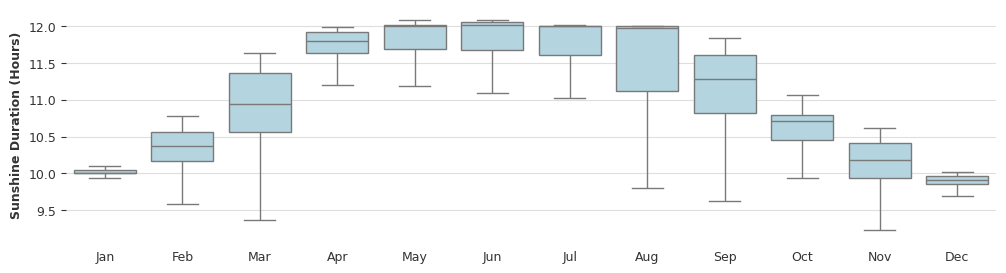

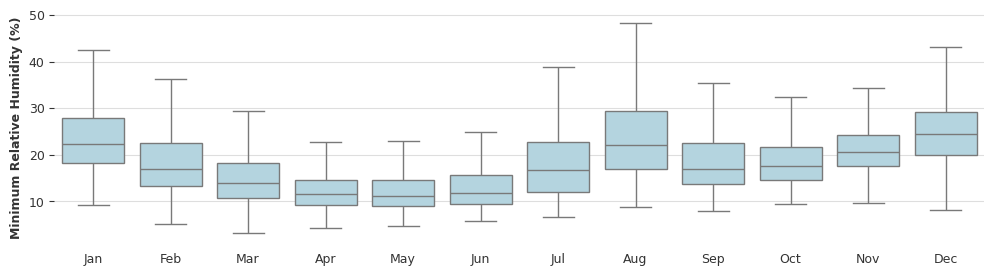

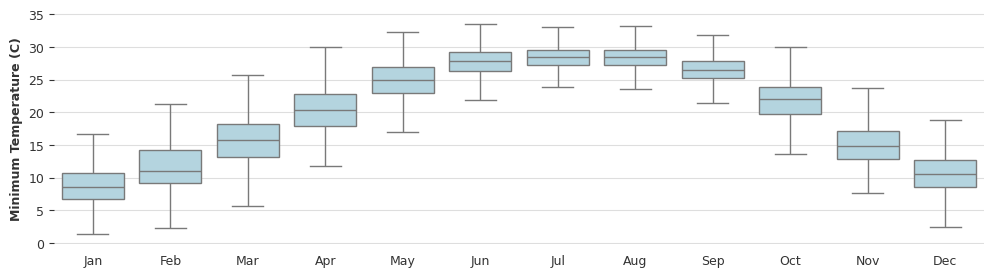

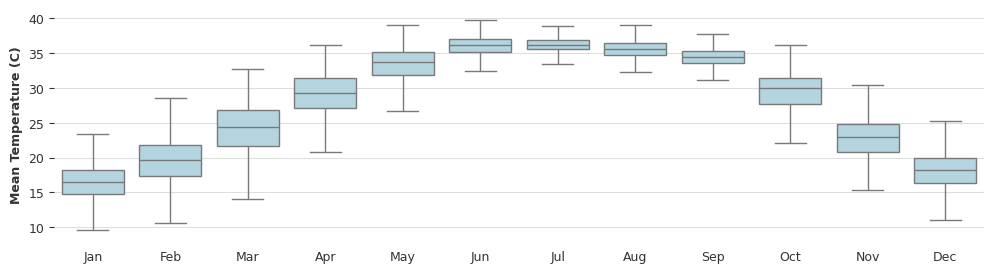

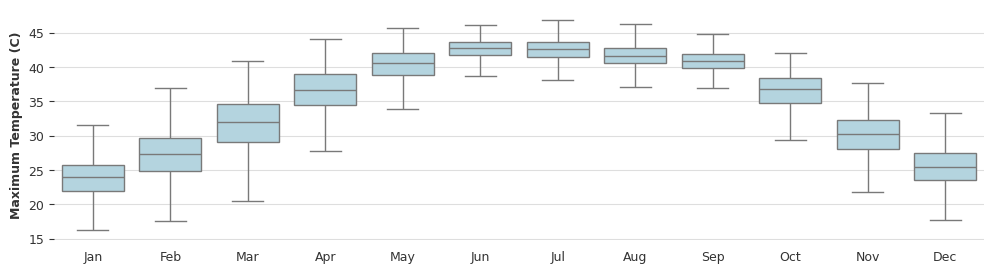

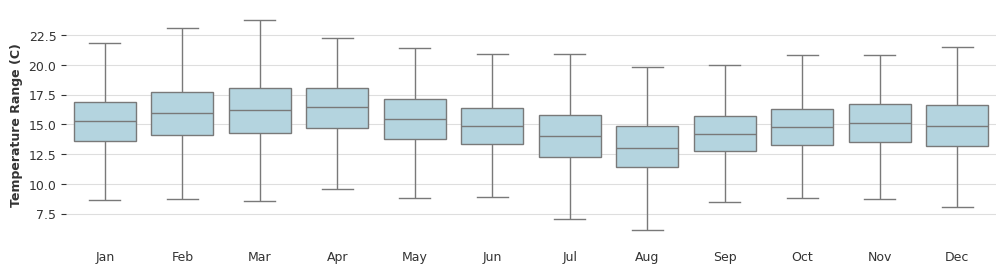

In [ ]:
# Clean data boxplots
vf.generate_boxplots(data=df_clean, columns=cols_to_plot, granularity='month',
                     alternate_x_labels=month_label_abbr, y_labels=y_labels,
                    figsize=(12,3), label_font_size=9, tick_font_size=9)

Clearing the outliers has shrunk the SD range from 12 hours to less than 3 hours (~9.2h to 12h), which may have some implication for the experiment results. This smaller range could potentially leave room for the overestimation of model performance.

In [ ]:
df_daily.drop(['year', 'month', 'day_of_year'], axis=1, inplace=True)
df_daily.to_csv(f'{DIR_PROCESSED}data_bbm_outliers.csv')
df_clean.drop(['year', 'month', 'day_of_year'], axis=1, inplace=True)
df_clean.to_csv(f'{DIR_PROCESSED}data_bbm_clean.csv')

data_bbm_outliers = df_daily.copy()
data_bbm_clean = df_clean.copy()

## Preliminary Experiment: Selecting a Naive Baseline Model

In order to ensure proper performance contextualization for both the novel and traditional ML models, a preliminary experiment is conducted to select a baseline comparator model. The performance of the baseline models provided by Darts is tested, and a final selection is made based on rmse and mae scores. A date other than the one generated for the main experiments is used, to avoid biasing the results. The same date will be used in the hyperparameter selection section.


In [ ]:
seed = 34
FORECAST_HORIZONS = (1, 3, 7, 14, 28)

naive_models = ['naive_drift', 'naive_seasonal', 'naive_mean', 'naive_moving_average']
cutoff_date = pf.generate_cutoff_date(start_date='2023-01-01', end_date='2023-12-03', seed=seed, n=1)
print(f'\nSelected cutoff date: {cutoff_date}')

for version in ['outliers', 'clean']:
    print(f'\n---------- Dataset Type: {version} ----------\n')

    if version == 'outliers':
        target_train, target_test, _ = pf.train_test_split(cutoff_date, df_outliers=data_bbm_outliers,  has_outliers=True)
    else:
        target_train, target_test, _ = pf.train_test_split(cutoff_date, df_clean=data_bbm_clean,  has_outliers=False)

    avg_metrics, median_metrics = pf.get_naive_model_metrics(naive_models, FORECAST_HORIZONS,
                                                        train_data=target_train, test_data=target_test)
    print('\nAverage Error:', '\n')
    display(avg_metrics)
    print('\n')
    print('Median Error:', '\n')
    display(median_metrics)


Selected cutoff date: 2023-08-24

---------- Dataset Type: outliers ----------


Average Error: 



,model_name,rmse,mae
0,naive_drift,0.722636,0.458631
1,naive_mean,0.751342,0.466973
2,naive_moving_average,0.820939,0.783551
3,naive_seasonal,3.997902,3.302006




Median Error: 



,model_name,rmse,mae
0,naive_drift,0.774466,0.430788
2,naive_moving_average,0.819931,0.765991
1,naive_mean,0.845352,0.504116
3,naive_seasonal,3.613701,2.652277



---------- Dataset Type: clean ----------


Average Error: 



,model_name,rmse,mae
0,naive_drift,0.421124,0.307636
2,naive_moving_average,0.487098,0.449184
1,naive_mean,0.519673,0.393101
3,naive_seasonal,0.836710,0.768856




Median Error: 



,model_name,rmse,mae
0,naive_drift,0.445767,0.288900
2,naive_moving_average,0.502503,0.489075
1,naive_mean,0.637889,0.471184
3,naive_seasonal,0.796311,0.721739


Naive Drift displays the best performance in terms of both average and median error, so it is selected as the baseline comparator.


## Preliminary Experiment: Optuna vs. Grid Search

This experiment has two parts, with the first being the training of a random forest (RF) model on BBM data from 2002-2006, and comparing its performance to that obtained in El-kenawy et al. (2021)'s ensemble learning model experiment. The second part is assessing the respective performances of the Optuna hyperparameter optimization framework and Grid Search (GS) in arriving at optimal hyperparameters for the random forest model. The goal is to validate Optuna's ability to provide good results, as well as demonstrate its potential efficiency relative to GS.


In the referenced study:
- The dataset was "divided randomly into three subsets of training, validation, and testing (60, 20, and 20%, respectively)." However, given its time series nature, such a step carries the risk of data leakage because future data is dependent on past data, and information pertaining to the test set may inadvertently find its way into the training set. For the purposes of the current study, a cutoff date will be used instead.
- The parameters for the RF model were not disclosed.
- The fields used for SD prediction were: Relative Humidity (daily average relative humidity), Mean Air Temperature, Maximum Air Temperature, and Minimum Air Temperature.
- SD values were normalized using the min-max scaling method, and all the reported SD and associated RMSE and MSE values were dimensionless.

**Note:** the reported results for this part were from a locally run version of the experiment, as the Colab CPU instance took over twice as long to complete the GS search.

In [ ]:
subset = data_bbm_outliers.loc[(data_bbm_outliers.index.year >= 2002) & (data_bbm_outliers.index.year <= 2006)]
subset.drop('temp_range', axis=1, inplace=True)

# BBM RF results in El-kenawy et al study
comparison_rmse = 0.2164
comparison_mae = 0.1633

target = pf.create_timeseries(subset, 'sunshine_hr')
past_covariates = pf.get_covariate_ts(subset)

series_len = len(subset)
test_len = round(.2 * series_len)

# create training, testing, and validation datasets -> 60%-20%-20% split required
# '_main': for main test; '_sub': for validation process, pre-testing

target_train_main, target_test = target[:-test_len], target[-test_len:]
target_train_sub, target_val = target_train_main[:-test_len], target_train_main[-test_len:]

target_scaler1 = Scaler()
target_train_main_scaled = target_scaler1.fit_transform(target_train_main)
target_test_scaled = target_scaler1.transform(target_test)

target_scaler2 = Scaler()
target_train_sub_scaled = target_scaler2.fit_transform(target_train_sub)
target_val_scaled = target_scaler2.transform(target_val)

cov_train_main = past_covariates[:-test_len]
cov_train_sub = cov_train_main[:-test_len]

cov_scaler1 = Scaler()
cov_train_main_scaled = cov_scaler1.fit_transform(cov_train_main)
cov_scaler2 = Scaler()
cov_train_sub_scaled = cov_scaler2.fit_transform(cov_train_sub)


In [ ]:
print(f'2002-2006 data length: {series_len}\n')
print(f'Full Training Data: {len(target_train_main)/series_len:.1%} of total dataset')
print(f'Sub Training Data: {len(target_train_sub)/series_len:.1%} of total dataset')
print(f'Validation Data: {len(target_val)/series_len:.1%} of total dataset')
print(f'Test Data: {len(target_test)/series_len:.1%} of total dataset')


2002-2006 data length: 1826

Full Training Data: 80.0% of total dataset
Sub Training Data: 60.0% of total dataset
Validation Data: 20.0% of total dataset
Test Data: 20.0% of total dataset


In [ ]:
# hyperparameter search space
LAGS = [1, 3, 7, 14, 28, 60, 90, 120]
N_ESTIMATORS = [50, 100, 150, 200]
MAX_DEPTHS = [2, 3, 5, 8]

### Optuna

In [ ]:
all_results = {}
hyperparam_file_rf = f'{DIR_HYPERPARAMS_OUTLIERS}prelim_experiments_search_results_rf.json'
n_trials = 35

def objective_rf_prelim(trial):
    """Random Forest hyperparameter search objective"""

    # hyperparameter space
    rf_params = {
                    'lags': trial.suggest_categorical("lags", LAGS),
                    'lags_past_covariates': trial.suggest_categorical('lags_past_covariates', LAGS),
                    'n_estimators': trial.suggest_categorical('n_estimators', N_ESTIMATORS),
                    'max_depth': trial.suggest_categorical('max_depth',  MAX_DEPTHS),
                    'output_chunk_length': test_len
                    }

    model = RandomForest(**rf_params)

    model.fit(
                series=target_train_sub_scaled,
                past_covariates=cov_train_sub_scaled,
                )

    predictions_scaled = model.predict(
                                        n=test_len,
                                        series=target_train_sub_scaled,
                                        past_covariates=cov_train_sub_scaled,
                                        )

    rmse_result_scaled = rmse(predictions_scaled, target_val_scaled)

    return rmse_result_scaled

study = optuna.create_study(direction='minimize')
start_time = time.perf_counter()
study.optimize(objective_rf_prelim, n_trials)
end_time = time.perf_counter()
optuna_search_time = round((end_time - start_time)/60, 2)
print(f'Optuna Trials completed in {optuna_search_time} minutes')
print(f'Best RMSE (Scaled): {study.best_value:.4f}\nBest parameters: {study.best_trial.params}')

Optuna Trials completed in 13.63 minutes
Best RMSE (Scaled): 0.0841
Best parameters: {'lags': 28, 'lags_past_covariates': 120, 'n_estimators': 150, 'max_depth': 2}


In [ ]:
optuna_results = study.best_trial.params
optuna_results['search_time'] = optuna_search_time
optuna_results['rmse'] = study.best_value
all_results['optuna_results'] = optuna_results
pf.post_results(all_results, hyperparam_file_rf, 'w')


Successfully posted results to results/hyperparam_tuning/prelim_experiments_search_results_rf.json


### Grid Search

In [ ]:
parameters_rf = {
            'lags': LAGS,
            'lags_past_covariates': LAGS,
            'n_estimators': N_ESTIMATORS,
            'max_depth': MAX_DEPTHS,
            'output_chunk_length': [test_len]
        }

start_time = time.perf_counter()
grid_search_model, grid_search_results, rmse_grid_search = RandomForest.gridsearch(
                parameters=parameters_rf,
                series=target_train_sub_scaled,
                past_covariates=cov_train_sub_scaled,
                val_series=target_val_scaled,
                use_fitted_values=False,
                metric=rmse
            )
end_time = time.perf_counter()
gs_search_time = round((end_time - start_time)/60, 2)
print(f'Grid Search completed in {gs_search_time} minutes')
print(f'Best RMSE: {rmse_grid_search:.4f}\nBest parameters: {grid_search_results}')

Grid Search completed in 347.89 minutes
Best RMSE: 0.0831
Best parameters: {'lags': 3, 'lags_past_covariates': 14, 'n_estimators': 150, 'max_depth': 5, 'output_chunk_length': 365}


The grid search returns the following: 1) a tuple containing an *untrained* model_class instance created from the best-performing hyper-parameters; 2) a dictionary containing these best hyper-parameters; and 3)the metric score for the best hyper-parameters.

In [ ]:
grid_search_results['search_time'] = gs_search_time
grid_search_results['rmse'] = rmse_grid_search
all_results['grid_search_results'] = grid_search_results
pf.post_results(all_results, hyperparam_file_rf, 'w')

In [ ]:
print(f'Grid Search took {gs_search_time/optuna_search_time:.1f} times as long as Optuna to produce similar results ({optuna_search_time} minutes vs. {gs_search_time/60:.1f} hours).')

Grid Search took 25.5 times as long as Optuna to produce similar results (13.63 minutes vs. 5.8 hours).


### Tests

#### Optuna

In [ ]:
optuna_model = RandomForest(
                    lags=optuna_results['lags'],
                    lags_past_covariates=optuna_results['lags_past_covariates'],
                    n_estimators=optuna_results['n_estimators'],
                    max_depth=optuna_results['max_depth'],
                    output_chunk_length=test_len
                    )

optuna_model.fit(series=target_train_main_scaled,
                past_covariates=cov_train_main_scaled)

predictions = optuna_model.predict(
                                n=test_len,
                                series=target_train_main_scaled,
                                past_covariates=cov_train_main_scaled
                                )

rmse_score_o = rmse(predictions, target_test_scaled)
mae_score_o = mae(predictions, target_test_scaled)

print(f"RMSE score of {rmse_score_o:.4f} vs. El-kenawy et al.'s reported {comparison_rmse} RMSE.")
print(f"MAE score of {mae_score_o:.4f} vs. El-kenawy et al.'s reported {comparison_mae} MAE.")

RMSE score of 0.0962 vs. El-kenawy et al.'s reported 0.2164 RMSE.
MAE score of 0.0377 vs. El-kenawy et al.'s reported 0.1633 MAE.


#### Grid Search

In [ ]:
grid_search_model.fit(series=target_train_main_scaled,
                    past_covariates=cov_train_main_scaled)

predictions = grid_search_model.predict(
                                n=test_len,
                                series=target_train_main_scaled,
                                past_covariates=cov_train_main_scaled
                                )

rmse_score_g = rmse(predictions, target_test_scaled)
mae_score_g = mae(predictions, target_test_scaled)

print(f"RMSE score of {rmse_score_g:.4f} vs. El-kenawy et al.'s reported {comparison_rmse} RMSE.")
print(f"MAE score of {mae_score_g:.4f} vs. El-kenawy et al.'s reported {comparison_mae} MAE.")

RMSE score of 0.0970 vs. El-kenawy et al.'s reported 0.2164 RMSE.
MAE score of 0.0333 vs. El-kenawy et al.'s reported 0.1633 MAE.


In [ ]:
print(f"Optuna's RMSE and MAE scores are, respectively, {rmse_score_o - rmse_score_g:+.4f} and {mae_score_o - mae_score_g:+.4f} relative to GS's, \
and {(rmse_score_o - comparison_rmse)/comparison_rmse:+.1%} and {(mae_score_o - comparison_mae)/comparison_mae:+.1%} relative to El-kenawy et al's.\n")

print(f"GS's RMSE and MAE scores are, respectively, {(rmse_score_g - comparison_rmse)/comparison_rmse:+.1%} and {(mae_score_g - comparison_mae)/comparison_mae:+.1%} relative to El-kenawy et al's.\n")

Optuna's RMSE and MAE scores are, respectively, -0.0008 and +0.0044 relative to GS's, and -55.5% and -76.9% relative to El-kenawy et al's.

GS's RMSE and MAE scores are, respectively, -55.2% and -79.6% relative to El-kenawy et al's.



The tests once again confirm that Optuna and GS produce fairly similar results, with optimal hyperparameters that the former was able to determine in a fraction of the time taken by the latter. Furthermore, this study shows a ~55% improvement in RMSE and ~80% in MAE relative to the scores reported by El-kenawy et al.

## Hyperparameter Search for Main Experiment

### Set-up

In [ ]:
#TO DO: ADD CODE FOR CLEAN VS OUTLIER CONDITION

SEED = 25
BATCH_SIZES = [32, 64, 128, 256]
RMSE = 'rmse'
MAE = 'mae'
results_dict = {}

testing_cutoff_date = pd.Timestamp('2022-12-31') # save 2023 for main experiment testing
# cutoff/end date of Dec 3rd avoids errors, i.e. going beyond Dec 31 for Forecast Horizon=28
validation_cutoff_date = pd.Timestamp(pf.generate_cutoff_date(start_date='2022-01-01', end_date='2022-12-03', seed=SEED, n=1, replace=False))

for condition in ['outlier', 'clean']:

    if condition == 'outlier':
        target_train, _, cov_train = pf.train_test_split(cutoff_date=testing_cutoff_date, df_outliers=data_bbm_outliers, has_outliers=True)
    else:
        target_train, _, cov_train = pf.train_test_split(cutoff_date=testing_cutoff_date, df_clean=data_bbm_clean, has_outliers=False)

    target_train, target_val = target_train.split_after(validation_cutoff_date)
    cov_train, _ = cov_train.split_after(validation_cutoff_date)

    target_scaler = Scaler()
    target_train_scaled = target_scaler.fit_transform(target_train)
    cov_scaler = Scaler()
    cov_train_scaled = cov_scaler.fit_transform(cov_train)

    if condition == 'outlier':

        common_inputs_outl = {
            'scaled_data': {
                'target_train': target_train_scaled,
                'cov_train': cov_train_scaled,
                'target_scaler': target_scaler,
                },
            'unscaled_data': {
                'target_train': target_train,
                'cov_train': cov_train,
            },
            'target_test': target_val,
            'batch_sizes': BATCH_SIZES,
            'seed': SEED
        }

    else:
        common_inputs_cl = {
            'scaled_data': {
                'target_train': target_train_scaled,
                'cov_train': cov_train_scaled,
                'target_scaler': target_scaler,
                },
            'unscaled_data': {
                'target_train': target_train,
                'cov_train': cov_train,
            },
            'target_test': target_val,
            'batch_sizes': BATCH_SIZES,
            'seed': SEED
        }


In [ ]:
print(f'Testing cut-off date: {testing_cutoff_date.strftime("%Y-%m-%d")}')
print(f'Validation cut-off date: {validation_cutoff_date.strftime("%Y-%m-%d")}\n')

print('Target Train Head: \n')
print(target_train.head(1), '\n')
print('\nTarget Train Tail: \n')
print(target_train.tail(1), '\n')

print('\nCov Train Head: \n')
print(cov_train.head(1), '\n')
print('\nCov Train Tail: \n')
print(cov_train.tail(1))

print('\nTarget Validation Head: \n')
print(target_val.head(1))


Testing cut-off date: 2022-12-31
Validation cut-off date: 2022-08-10

Target Train Head: 

<TimeSeries (DataArray) (date: 1, component: 1, sample: 1)> Size: 4B
array([[[10.]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 8B 1994-01-01
  * component  (component) object 8B 'sunshine_hr'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None 


Target Train Tail: 

<TimeSeries (DataArray) (date: 1, component: 1, sample: 1)> Size: 4B
array([[[9.799182]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 8B 2022-08-10
  * component  (component) object 8B 'sunshine_hr'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None 


Cov Train Head: 

<TimeSeries (DataArray) (date: 1, component: 5, sample: 1)> Size: 20B
array([[[29.833334],
        [ 5.9     ],
        [13.366667],
        [20.8     ],
        [14.9     ]]], dtype=float32)
Coordinates:
  * 

### Search

In [ ]:
n_trials = 50

MODELS = ['lstm', 'gru', 'nbeats' 'nhits', 'rf', 'xgboost', 'lgbm'] # all models
# MODELS = ['lstm', 'gru', 'nbeats' 'nhits'] # DL models - for GPU purposes
# MODELS = ['rf', 'xgboost', 'lgbm'] # non-DL models - don't require GPU

for version in ['outlier', 'clean']:

    if version == 'outlier':
        directory = DIR_HYPERPARAMS_OUTLIERS
        common_inputs = common_inputs_outl
    else:
        directory = DIR_HYPERPARAMS_CLEAN
        common_inputs = common_inputs_cl

    for model_name in MODELS:
        hyperparam_file = f'{directory}optuna_results_{model_name}_{version}version.json'
        results_dict = {}

        for fh in FORECAST_HORIZONS:

            if model_name in ['lstm', 'gru']:
                hp.hyperparameter_search(fh, model_name, common_inputs, n_trials, results_dict,
                            hyperparam_file, version=model_name, error_metric=RMSE, seed=SEED, results_directory=directory)
            elif model_name == 'nbeats':
                n_trials = 20
                hp.hyperparameter_search(fh, model_name, common_inputs, n_trials, results_dict,
                            hyperparam_file, version='generic', error_metric=RMSE, seed=SEED, results_directory=directory)
            else:
                if model_name == 'nhits':
                    n_trials = 20
                hp.hyperparameter_search(fh, model_name, common_inputs, n_trials, results_dict,
                            hyperparam_file, version=None, error_metric=RMSE, seed=SEED, results_directory=directory)


## Main Experiments

Note: Image Titles are ommitted for the purposes of inclusion in the major research paper, where figure names will be used instead.

### Hyperparameter compilation

In [ ]:
SEED = 50
MODEL_NAMES = {
    'naive_drift': 'Naive Drift',
    'ets': 'Exponential Smoothing',
    'rf': 'Random Forest',
    'xgboost': 'XGBoost',
    'lgbm': 'LightGBM',
    'lstm': 'LSTM',
    'gru': 'GRU',
    'nbeats': 'N-BEATS',
    'nhits': 'N-HiTS'
}

for version in ['outlier', 'clean']:

    if version == 'outlier':
        directory = DIR_HYPERPARAMS_OUTLIERS
    else:
        directory = DIR_HYPERPARAMS_CLEAN

    # compile hyperparameter search results
    hyperparams_file = f'{directory}optuna_results_{version}version.json'
    hyperparams = {}

    for name in MODEL_NAMES.keys():
        if name in ['naive_drift', 'ets']:
            continue
        try:
            hyperprms = pf.read_json_file(f'{directory}optuna_results_{name}_{version}version.json')
            hyperparams.update(hyperprms)
        except:
            continue

    pf.post_results(hyperparams, hyperparams_file, mode='w')

    # reformat the hyperparameter dictionary
    if version == 'outlier':
        hyparams_reformatted_outl = pf.get_reformatted_hyperparams(hyperparams, forecast_horizons=FORECAST_HORIZONS)
    else:
        hyparams_reformatted_cl = pf.get_reformatted_hyperparams(hyperparams, forecast_horizons=FORECAST_HORIZONS)


# generate cut-off date for the experiments (i.e. the next 1-28 days after the cutoff will become test data)
cutoff_date = pf.generate_cutoff_date(start_date='2023-01-01', end_date='2023-12-03', seed=SEED, n=1)
cutoff_date2 = pf.generate_cutoff_date(start_date='2023-08-01', end_date='2023-08-31', seed=SEED, n=1)
print(f'\nThe randomly selected cutoff_date for the main experiments is: {cutoff_date}')
print(f'\nThe randomly selected cutoff_date for the main experiments w/ same month as validation is: {cutoff_date2}')



Successfully posted results to results/outlier_experiments/hyperparam_tuning/optuna_results_outlierversion.json

Successfully posted results to results/clean_experiments/hyperparam_tuning/optuna_results_cleanversion.json

The randomly selected cutoff_date for the main experiments is: 2023-04-09

The randomly selected cutoff_date for the main experiments w/ same month as validation is: 2023-08-19


In [ ]:
april = cutoff_date
august = cutoff_date2

for condition in ['outlier', 'clean']:

    if condition == 'outlier':
        models_directory = DIR_MODELS_OUTLIERS
        results_directory = DIR_MODEL_RESULTS_OUTLIERS
        hyparams_reformatted = hyparams_reformatted_outl
    else:
        models_directory = DIR_MODELS_CLEAN
        results_directory = DIR_MODEL_RESULTS_CLEAN
        hyparams_reformatted = hyparams_reformatted_cl

    for cutoff_date in [april, august]:
        # print(f'CUTOFF DATE: {cutoff_date}\n')

        for model_name in ['naive_drift', 'ets', 'rf', 'xgboost', 'lgbm', 'lstm', 'gru', 'nbeats', 'nhits']:

            results = {
                        'model_name_proper': [],
                        'model_name_fh': [],
                        'model_type': [],
                        'has_outliers': [],
                        'forecast_horizon': [],
                        'rmse': [],
                        'mae': [],
                        'n_epochs': [],
                        'has_n_epochs_override': [],
                        'training_time': [],
                        'hyp_search_time': [],
                        'best_val_rmse': [],
                        'total_time': []
                    }

            for model_type in ['default', 'tuned']:
                if model_name == 'nbeats':
                    for version in ['generic', 'interpretable']:
                        if version == 'interpretable' and model_type == 'tuned':
                            continue

                        for has_outliers in [True, False]:

                            for fh in FORECAST_HORIZONS:

                                if model_type == 'default':

                                    n_epochs_override = None

                                    model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                version=version, model_type=model_type, n_epochs_override=n_epochs_override)

                                    model_name_proper = MODEL_NAMES[model_name]
                                    model_names = [model_name, model_name_proper, model_name_fh]

                                    pf.run_experiment(model, model_names, n_epochs_override, hyperparameters=hyperparams, cutoff_date=cutoff_date, fh=fh,
                                            df_outliers=data_bbm_outliers, df_clean=data_bbm_clean, has_outliers=has_outliers, results=results,
                                            models_directory=models_directory, results_directory=results_directory)
                                else:

                                    for n_epochs_override in [None, 100]:

                                        model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                    version=version, model_type=model_type, n_epochs_override=n_epochs_override)

                                        model_name_proper = MODEL_NAMES[model_name]
                                        model_names = [model_name, model_name_proper, model_name_fh]

                                        pf.run_experiment(model, model_names, n_epochs_override, hyperparameters=hyperparams, cutoff_date=cutoff_date, fh=fh,
                                                df_outliers=data_bbm_outliers, df_clean=data_bbm_clean, has_outliers=has_outliers, results=results,
                                                models_directory=models_directory, results_directory=results_directory)

                else:

                    for has_outliers in [True, False]:
                            for fh in FORECAST_HORIZONS:
                                if model_type == 'default':
                                    n_epochs_override = None

                                    if model_name in ['lstm', 'gru']:
                                        version = model_name.upper()
                                        model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                version=version, model_type=model_type, n_epochs_override=n_epochs_override)
                                    else:
                                        model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                            model_type=model_type, n_epochs_override=n_epochs_override)

                                    model_name_proper = MODEL_NAMES[model_name]
                                    model_names = [model_name, model_name_proper, model_name_fh]

                                    pf.run_experiment(model, model_names, n_epochs_override, hyperparameters=hyperparams, cutoff_date=cutoff_date, fh=fh,
                                            df_outliers=data_bbm_outliers, df_clean=data_bbm_clean, has_outliers=has_outliers, results=results,
                                            models_directory=models_directory, results_directory=results_directory)

                                else:

                                    if model_name in ['naive_drift', 'ets']:
                                        continue

                                    for n_epochs_override in [None, 100]:

                                        if model_name in ['lstm', 'gru']:
                                            version = model_name.upper()
                                            model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                    version=version, model_type=model_type, n_epochs_override=n_epochs_override)
                                        else:
                                            model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                model_type=model_type, n_epochs_override=n_epochs_override)

                                        model_name_proper = MODEL_NAMES[model_name]
                                        model_names = [model_name, model_name_proper, model_name_fh]

                                        pf.run_experiment(model, model_names, n_epochs_override, hyperparameters=hyperparams, cutoff_date=cutoff_date, fh=fh,
                                                df_outliers=data_bbm_outliers, df_clean=data_bbm_clean, has_outliers=has_outliers, results=results,
                                                models_directory=models_directory, results_directory=results_directory)




In [ ]:
outlier_condition = 'Hyperparam-Outlier'
clean_condition = 'Hyperparam-Clean'

DIR_APRIL_OUTL = f'{DIR_MODEL_RESULTS_OUTLIERS}cutoff_date={april}/'
DIR_APRIL_CL = f'{DIR_MODEL_RESULTS_CLEAN}cutoff_date={april}/'
DIR_AUGUST_OUTL = f'{DIR_MODEL_RESULTS_OUTLIERS}cutoff_date={august}/'

res_nd_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}naive_drift_cutoffdate={april}_results.csv')
res_ets_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}ets_cutoffdate={april}_results.csv')
res_rf_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}rf_cutoffdate={april}_results.csv')
res_xgb_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}xgboost_cutoffdate={april}_results.csv')
res_lgbm_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}lgbm_cutoffdate={april}_results.csv')
res_lstm_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}lstm_cutoffdate={april}_results.csv')
res_gru_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}gru_cutoffdate={april}_results.csv')
res_nbeats_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}nbeats_cutoffdate={april}_results.csv')
res_nhits_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}nhits_cutoffdate={april}_results.csv')

res_april_outl = pd.concat([res_nd_april_outl, res_ets_april_outl, res_rf_april_outl, res_xgb_april_outl, res_lgbm_april_outl,
                            res_lstm_april_outl, res_gru_april_outl, res_nbeats_april_outl, res_nhits_april_outl],
                            axis=0).reset_index(drop=True)

res_april_outl['experiment_condition'] = outlier_condition

res_nd_april_cl = pd.read_csv(f'{DIR_APRIL_CL}naive_drift_cutoffdate={april}_results.csv')
res_ets_april_cl = pd.read_csv(f'{DIR_APRIL_CL}ets_cutoffdate={april}_results.csv')
res_rf_april_cl = pd.read_csv(f'{DIR_APRIL_CL}rf_cutoffdate={april}_results.csv')
res_xgb_april_cl = pd.read_csv(f'{DIR_APRIL_CL}xgboost_cutoffdate={april}_results.csv')
res_lgbm_april_cl = pd.read_csv(f'{DIR_APRIL_CL}lgbm_cutoffdate={april}_results.csv')
res_lstm_april_cl = pd.read_csv(f'{DIR_APRIL_CL}lstm_cutoffdate={april}_results.csv')
res_gru_april_cl = pd.read_csv(f'{DIR_APRIL_CL}gru_cutoffdate={april}_results.csv')
res_nbeats_april_cl = pd.read_csv(f'{DIR_APRIL_CL}nbeats_cutoffdate={april}_results.csv')
res_nhits_april_cl = pd.read_csv(f'{DIR_APRIL_CL}nhits_cutoffdate={april}_results.csv')

res_april_cl = pd.concat([res_nd_april_cl, res_ets_april_cl, res_rf_april_cl, res_xgb_april_cl, res_lgbm_april_cl,
                            res_lstm_april_cl, res_gru_april_cl, res_nbeats_april_cl, res_nhits_april_cl],
                            axis=0).reset_index(drop=True)

res_april_cl['experiment_condition'] = clean_condition

res_nd_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}naive_drift_cutoffdate={august}_results.csv')
res_ets_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}ets_cutoffdate={august}_results.csv')
res_rf_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}rf_cutoffdate={august}_results.csv')
res_xgb_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}xgboost_cutoffdate={august}_results.csv')
res_lgbm_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}lgbm_cutoffdate={august}_results.csv')
res_lstm_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}lstm_cutoffdate={august}_results.csv')
res_gru_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}gru_cutoffdate={august}_results.csv')
res_nbeats_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}nbeats_cutoffdate={august}_results.csv')
res_nhits_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}nhits_cutoffdate={august}_results.csv')

res_august_outl = pd.concat([res_nd_august_outl, res_ets_august_outl, res_rf_august_outl, res_xgb_august_outl, res_lgbm_august_outl,
                            res_lstm_august_outl, res_gru_august_outl, res_nbeats_august_outl, res_nhits_august_outl],
                            axis=0).reset_index(drop=True)

res_august_outl['experiment_condition'] = outlier_condition

res_april_outl['cutoff_date'] = res_april_cl['cutoff_date'] = cutoff_date
res_august_outl['cutoff_date'] = cutoff_date2


experiment_results = pd.concat([res_april_outl, res_april_cl, res_august_outl], axis=0).reset_index(drop=True)
experiment_results['FH'] = experiment_results.apply(lambda row: f'FH-{row["forecast_horizon"]}', axis=1)
experiment_results_backup = experiment_results.copy()


experiment_results.to_csv(f'{DIR_RESULTS}experiment_results_compiled.csv', index=False)


### **1. What was the performance difference between Optuna-derived num_epochs and epoch override of 100 (i.e. same as for the default)?**


In [6]:
RMSE = 'rmse'
MAE = 'mae'
error_metric = RMSE

pd.set_option('display.max_colwidth', None)

deep_models = ['LSTM', 'GRU', 'N-BEATS', 'N-HiTS']

experiment_results['unique_id'] = experiment_results['model_name_fh'] + '-Outliers-' + experiment_results['has_outliers'].astype(str) + '-' \
                            + experiment_results['experiment_condition']  + '-' + experiment_results['cutoff_date']

deep_tuned = experiment_results[(experiment_results['model_name_proper'].isin(deep_models)) \
                                & (experiment_results['model_type'] == 'tuned') \
                                & (experiment_results['experiment_condition'] == outlier_condition)] # all Tuned models had epoch override of 100 applied in the HP-Clean April condition

overr_compar_rmse = deep_tuned[['unique_id', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
                    .pivot_table(index=['unique_id', 'model_name_proper', 'has_outliers'], columns='has_n_epochs_override', values=error_metric)\
                    .reset_index()

overr_compar_rmse['best_model'] = overr_compar_rmse.apply(lambda row: 'No Epoch Override' if row[False] < row[True]
                                          else 'Epoch Override',axis=1)

overr_compar_rmse.rename(columns={False: 'no_epoch_override', True: 'epoch_override'}, inplace=True)

print('\n\nWin Proportion')
print('----------')
display(overr_compar_rmse['best_model'].value_counts(normalize=True))




Win Proportion
----------


,proportion
best_model,
Epoch Override,0.6375
No Epoch Override,0.3625


In [7]:
# Check for Null values
best_models_df = experiment_results.merge(overr_compar_rmse[['unique_id', 'best_model']], how='left')
display(best_models_df[(best_models_df['model_type'] == 'tuned') & (experiment_results['rmse'].isna())])

,model_name_proper,model_name_fh,model_type,has_outliers,forecast_horizon,rmse,mae,n_epochs,has_n_epochs_override,training_time,hyp_search_time,best_val_rmse,total_time,experiment_condition,cutoff_date,FH,unique_id,best_model
165,N-BEATS,nbeats_tuned_generic_fh7,tuned,True,7,NaN,NaN,100.0,True,22.31,327.74,0.6381,350.05,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,Epoch Override


For some reason, this experimental case with the epoch override of 100 resulted in NaN values for both metrics. The best model in this case will be adjusted to 'No Epoch Override.'

In [8]:
display(best_models_df[(best_models_df['model_name_fh'] == 'nbeats_tuned_generic_fh7') \
                       & (best_models_df['has_outliers'] == True)
                       & (best_models_df['cutoff_date'] == april)])

best_models_df.at[164, 'best_model'] = 'No Epoch Override'
best_models_df.at[165, 'best_model'] = 'No Epoch Override'

display(best_models_df[(best_models_df['model_name_fh'] == 'nbeats_tuned_generic_fh7') \
                       & (best_models_df['has_outliers'] == True)
                       & (best_models_df['cutoff_date'] == april)])

,model_name_proper,model_name_fh,model_type,has_outliers,forecast_horizon,rmse,mae,n_epochs,has_n_epochs_override,training_time,hyp_search_time,best_val_rmse,total_time,experiment_condition,cutoff_date,FH,unique_id,best_model
164,N-BEATS,nbeats_tuned_generic_fh7,tuned,True,7,1.7855,1.4392,73.0,False,16.187,327.74,0.6381,343.927,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,Epoch Override
165,N-BEATS,nbeats_tuned_generic_fh7,tuned,True,7,NaN,NaN,100.0,True,22.310,327.74,0.6381,350.050,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,Epoch Override


,model_name_proper,model_name_fh,model_type,has_outliers,forecast_horizon,rmse,mae,n_epochs,has_n_epochs_override,training_time,hyp_search_time,best_val_rmse,total_time,experiment_condition,cutoff_date,FH,unique_id,best_model
164,N-BEATS,nbeats_tuned_generic_fh7,tuned,True,7,1.7855,1.4392,73.0,False,16.187,327.74,0.6381,343.927,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,No Epoch Override
165,N-BEATS,nbeats_tuned_generic_fh7,tuned,True,7,NaN,NaN,100.0,True,22.310,327.74,0.6381,350.050,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,No Epoch Override


Select winning model variant for each epoch override/no epoch override case:

In [9]:
non_dl_models = ['Naive Drift', 'Exponential Smoothing', 'Random Forest', 'XGBoost', 'LightGBM']

best_models_df2 = best_models_df[ (best_models_df['model_type'] == 'default') #all default model versions
                                 | (best_models_df['model_name_proper'].isin(non_dl_models))   # all non_dl models
                                 | (best_models_df['experiment_condition'] == clean_condition)  # all HP-Clean condition had override of 100 epoch
                                 | ( (best_models_df['model_type'] == 'tuned') & (best_models_df['model_name_proper'].isin(deep_models))
                                          & (best_models_df['has_n_epochs_override'] == True)  & (best_models_df['best_model'] == 'Epoch Override') )  # Tuned models w/ override where override was best
                                 | ( (best_models_df['model_type'] == 'tuned') & (best_models_df['model_name_proper'].isin(deep_models))
                                          & (best_models_df['has_n_epochs_override'] == False)  & (best_models_df['best_model'] == 'No Epoch Override') ) # Tuned models w/ no override where no override was best
                                ].reset_index(drop=True)

# Check that filtering was properly applied
model_name = 'N-BEATS'
cols = [ 'unique_id', 'model_name_proper', 'has_n_epochs_override', 'best_model',]
test = best_models_df2[(best_models_df2['model_name_proper'] == model_name) \
                       & (best_models_df2['experiment_condition'] == outlier_condition) \
                       & (best_models_df2['cutoff_date'] == august)]
test = test[cols].sort_values(by='unique_id').reset_index(drop=True)
test[~ (test['best_model'].isnull() )]

,unique_id,model_name_proper,has_n_epochs_override,best_model
20,nbeats_tuned_generic_fh1-Outliers-False-Hyperparam-Outlier-2023-08-19,N-BEATS,True,Epoch Override
21,nbeats_tuned_generic_fh1-Outliers-True-Hyperparam-Outlier-2023-08-19,N-BEATS,True,Epoch Override
22,nbeats_tuned_generic_fh14-Outliers-False-Hyperparam-Outlier-2023-08-19,N-BEATS,False,No Epoch Override
23,nbeats_tuned_generic_fh14-Outliers-True-Hyperparam-Outlier-2023-08-19,N-BEATS,False,No Epoch Override
24,nbeats_tuned_generic_fh28-Outliers-False-Hyperparam-Outlier-2023-08-19,N-BEATS,False,No Epoch Override
25,nbeats_tuned_generic_fh28-Outliers-True-Hyperparam-Outlier-2023-08-19,N-BEATS,True,Epoch Override
26,nbeats_tuned_generic_fh3-Outliers-False-Hyperparam-Outlier-2023-08-19,N-BEATS,True,Epoch Override
27,nbeats_tuned_generic_fh3-Outliers-True-Hyperparam-Outlier-2023-08-19,N-BEATS,True,Epoch Override
28,nbeats_tuned_generic_fh7-Outliers-False-Hyperparam-Outlier-2023-08-19,N-BEATS,True,Epoch Override
29,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-08-19,N-BEATS,False,No Epoch Override


In [10]:
# Rename models for easier display
best_models_df2['model_name'] = best_models_df2.apply(lambda row: 'RF-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'Random Forest'
                                                                  else 'RF-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'Random Forest'
                                                                  else 'XGB-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'XGBoost'
                                                                  else 'XGB-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'XGBoost'
                                                                  else 'LGBM-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'LightGBM'
                                                                  else 'LGBM-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'LightGBM'
                                                                  else 'LSTM-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'LSTM'
                                                                  else 'LSTM-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'LSTM'
                                                                  else 'GRU-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'GRU'
                                                                  else 'GRU-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'GRU'
                                                                  else 'NBEATS-G' if 'generic' in row['model_name_fh'] and row['model_type'] == 'default'
                                                                  else 'NBEATS-I' if 'interpretable' in row['model_name_fh']
                                                                  else 'NBEATS-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'N-BEATS'
                                                                  else 'NHiTS-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'N-HiTS'
                                                                  else 'NHiTS-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'N-HiTS'
                                                                  else 'ETS' if row['model_name_proper'] == 'Exponential Smoothing'
                                                                  else row['model_name_proper'],
                                                                  axis=1)

best_models_df2.shape

(425, 19)

### **2. What were the best and worst performing model variants for each of the forecast horizons?**


In [11]:
apr_data_outl_cond = best_models_df2[(best_models_df2['experiment_condition'] == outlier_condition) & (best_models_df2['cutoff_date'] == april)]
apr_data_cl_cond = best_models_df2[(best_models_df2['experiment_condition'] == clean_condition) & (best_models_df2['cutoff_date'] == april)]
aug_data_outl_cond = best_models_df2[(best_models_df2['experiment_condition'] == outlier_condition) & (best_models_df2['cutoff_date'] == august)]

required_columns = ['FH', 'model_name', 'has_outliers']
# error_metric = 'rmse'
index = ['has_outliers', 'model_name']



# Outlier Condition - April
rmse_outl_apr_outlCond, rmse_clean_apr_outlCond = pf.generate_error_table(apr_data_outl_cond, required_columns, index,
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=True)

mae_outl_apr_outlCond, mae_clean_apr_outlCond = pf.generate_error_table(apr_data_outl_cond, required_columns, index,
                                                        pivot_column='FH', error_metric=MAE, outlier_split=True)


# Clean Condition - April
rmse_clean_apr_clCond = pf.generate_error_table(apr_data_cl_cond, required_columns, index,
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=False)

mae_clean_apr_clCond = pf.generate_error_table(apr_data_cl_cond, required_columns, index,
                                                        pivot_column='FH', error_metric=MAE, outlier_split=False)


# Outlier Condition - August
rmse_outl_aug_outlCond, rmse_clean_aug_outlCond = pf.generate_error_table(aug_data_outl_cond, required_columns, index,
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=True)

mae_outl_aug_outlCond, mae_clean_aug_outlCond = pf.generate_error_table(aug_data_outl_cond, required_columns, index,
                                                        pivot_column='FH', error_metric=MAE, outlier_split=True)


**Note: ** The styling effects are lost upon download/upload; please refer to the pdf file for the highlighted min & max values.

#### HP-Outlier-Outlier Condition

In [12]:
sort_col = 'Median'
ascending = True

print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
rmse_outl_apr_outlCond.sort_values(by=sort_col, ascending=ascending,  inplace=True)
display(pf.highlight_min_max(df=rmse_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
mae_outl_apr_outlCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=mae_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))


print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: August ------------------\n')
print('\n-------- RMSE --------\n')
rmse_outl_aug_outlCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=rmse_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
mae_outl_aug_outlCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=mae_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))




------------------ Hyperparam-Outlier Condition - Outlier Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
NBEATS-I,0.112,1.987,1.731,1.300,1.296,1.300,1.288
RF-D,0.504,2.180,1.403,1.324,1.292,1.324,1.338
GRU-T,1.010,2.333,1.684,1.366,1.081,1.366,1.474
LSTM-D,0.198,2.122,1.579,1.371,1.192,1.371,1.306
RF-T,0.014,1.872,1.547,1.375,1.150,1.375,1.222
GRU-D,0.176,2.236,1.546,1.378,1.148,1.378,1.310
LGBM-D,0.248,1.847,1.637,1.391,1.246,1.391,1.293
XGB-D,0.092,1.454,1.697,1.510,1.220,1.454,1.238
LGBM-T,0.482,1.641,1.520,1.456,1.125,1.456,1.280



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
NBEATS-I,0.112,1.707,1.462,1.035,0.953,1.035,1.051
GRU-T,1.010,2.138,1.450,1.104,0.837,1.104,1.274
NBEATS-G,0.076,1.937,1.485,1.126,0.894,1.126,1.107
LGBM-T,0.482,1.342,1.365,1.135,0.937,1.135,1.066
ETS,0.998,2.291,1.559,1.139,0.907,1.139,1.339
GRU-D,0.176,1.925,1.323,1.146,0.979,1.146,1.116
LSTM-D,0.198,1.812,1.351,1.147,0.799,1.147,1.076
LGBM-D,0.248,1.493,1.447,1.172,1.029,1.172,1.094
LSTM-T,0.910,2.259,1.504,1.185,0.824,1.185,1.311




------------------ Hyperparam-Outlier Condition - Outlier Dataset: August ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
RF-D,0.387,1.462,1.131,0.914,0.802,0.914,0.935
LSTM-T,0.065,1.908,1.086,0.942,0.723,0.942,0.944
GRU-T,0.467,2.041,1.095,0.961,0.777,0.961,1.050
RF-T,0.976,1.498,1.077,0.979,0.816,0.979,1.054
NHiTS-T,0.018,1.479,1.089,0.988,0.787,0.988,0.891
GRU-D,0.543,1.446,1.002,1.001,0.764,1.001,0.959
LGBM-D,0.229,1.409,1.203,1.036,0.852,1.036,0.961
Naive Drift,1.004,1.422,1.139,1.041,0.906,1.041,1.092
LSTM-D,0.388,1.598,1.048,1.056,0.738,1.048,0.979



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
NBEATS-I,0.223,1.416,0.718,0.626,0.431,0.626,0.673
GRU-D,0.543,1.293,0.661,0.703,0.600,0.661,0.743
NHiTS-D,0.336,1.091,0.792,0.664,0.475,0.664,0.670
LSTM-D,0.388,1.061,0.762,0.698,0.551,0.698,0.693
NHiTS-T,0.018,1.271,0.848,0.703,0.498,0.703,0.674
LSTM-T,0.065,1.364,0.704,0.742,0.491,0.704,0.678
GRU-T,0.467,1.446,0.880,0.713,0.576,0.713,0.799
NBEATS-G,0.807,1.007,0.868,0.784,0.530,0.807,0.801
RF-D,0.387,1.143,0.886,0.814,0.636,0.814,0.780


#### HP-Outlier-Clean Condition

In [13]:
sort_col = 'Median'
ascending = True

print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
rmse_clean_apr_outlCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=rmse_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
mae_clean_apr_outlCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=mae_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))


print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: August ------------------\n')
print('\n-------- RMSE --------\n')
rmse_clean_aug_outlCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=rmse_clean_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
mae_clean_aug_outlCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=mae_clean_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))







------------------ Hyperparam-Outlier Condition - Clean Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
GRU-D,0.011,0.015,0.137,0.236,0.287,0.137,0.137
NHiTS-D,0.070,0.033,0.149,0.178,0.206,0.149,0.131
ETS,0.113,0.104,0.171,0.203,0.235,0.171,0.166
NHiTS-T,0.153,0.163,0.173,0.202,0.229,0.173,0.182
NBEATS-G,0.181,0.125,0.182,0.281,0.246,0.182,0.200
LGBM-T,0.049,0.154,0.182,0.242,0.242,0.182,0.175
GRU-T,0.005,0.128,0.183,0.217,0.228,0.183,0.157
RF-T,0.144,0.019,0.199,0.239,0.280,0.199,0.180
Naive Drift,0.000,0.000,0.201,0.244,0.336,0.201,0.164



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
Naive Drift,0.000,0.000,0.100,0.141,0.243,0.100,0.098
NHiTS-D,0.070,0.027,0.109,0.144,0.174,0.109,0.105
GRU-T,0.005,0.115,0.110,0.187,0.198,0.115,0.122
GRU-D,0.011,0.014,0.119,0.206,0.229,0.119,0.116
ETS,0.113,0.104,0.132,0.175,0.212,0.132,0.145
NBEATS-I,0.224,0.153,0.133,0.161,0.244,0.161,0.179
LGBM-T,0.049,0.154,0.162,0.216,0.177,0.162,0.153
NHiTS-T,0.153,0.162,0.103,0.175,0.201,0.162,0.159
LSTM-D,0.014,0.043,0.181,0.231,0.185,0.181,0.139




------------------ Hyperparam-Outlier Condition - Clean Dataset: August ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
NHiTS-D,0.323,0.456,0.363,0.431,0.375,0.375,0.387
NHiTS-T,0.240,0.383,0.414,0.436,0.362,0.383,0.370
RF-D,0.375,0.402,0.400,0.415,0.349,0.400,0.390
GRU-T,0.598,0.409,0.557,0.409,0.354,0.409,0.456
LGBM-T,0.423,0.433,0.403,0.417,0.363,0.417,0.409
NBEATS-I,0.306,0.434,0.420,0.420,0.352,0.420,0.392
LSTM-T,0.455,0.646,0.411,0.422,0.344,0.422,0.450
GRU-D,0.396,0.470,0.422,0.425,0.369,0.422,0.417
NBEATS-G,0.390,0.534,0.423,0.489,0.420,0.423,0.447



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
NHiTS-T,0.240,0.258,0.367,0.396,0.318,0.318,0.316
NBEATS-T,0.346,0.399,0.315,0.325,0.574,0.346,0.384
NHiTS-D,0.323,0.373,0.352,0.383,0.298,0.352,0.347
GRU-T,0.598,0.358,0.508,0.361,0.286,0.361,0.412
RF-D,0.375,0.344,0.373,0.383,0.287,0.373,0.356
LSTM-T,0.455,0.532,0.352,0.374,0.292,0.374,0.397
LSTM-D,0.470,0.375,0.423,0.356,0.273,0.375,0.379
LGBM-T,0.423,0.375,0.364,0.381,0.324,0.375,0.374
NBEATS-G,0.390,0.412,0.371,0.377,0.298,0.377,0.371


#### HP-Clean-Clean Condition

In [14]:
sort_col = 'Median'
ascending = True

print(f'\n\n------------------ {clean_condition} Condition - Clean Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
rmse_clean_apr_clCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=rmse_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
mae_clean_apr_clCond.sort_values(by=sort_col, ascending=ascending,   inplace=True)
display(pf.highlight_min_max(df=mae_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))






------------------ Hyperparam-Clean Condition - Clean Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
LSTM-D,0.028,0.057,0.133,0.249,0.235,0.133,0.139
ETS,0.113,0.104,0.171,0.203,0.235,0.171,0.166
Naive Drift,0.000,0.000,0.201,0.244,0.336,0.201,0.164
GRU-D,0.023,0.022,0.205,0.270,0.219,0.205,0.157
NHiTS-T,0.088,0.056,0.205,0.233,0.225,0.205,0.169
NBEATS-G,0.182,0.195,0.207,0.254,0.268,0.207,0.219
LSTM-T,0.009,0.339,0.191,0.219,0.223,0.219,0.200
RF-D,0.107,0.169,0.235,0.245,0.222,0.222,0.200
LGBM-T,0.131,0.103,0.231,0.223,0.241,0.223,0.192



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
Naive Drift,0.000,0.000,0.100,0.141,0.243,0.100,0.098
LSTM-D,0.028,0.057,0.106,0.219,0.209,0.106,0.121
GRU-D,0.023,0.021,0.108,0.232,0.201,0.108,0.116
ETS,0.113,0.104,0.132,0.175,0.212,0.132,0.145
LGBM-T,0.131,0.099,0.211,0.199,0.178,0.178,0.166
NHiTS-T,0.088,0.056,0.194,0.182,0.190,0.182,0.149
GRU-T,0.180,0.639,0.171,0.186,0.218,0.186,0.263
LSTM-T,0.009,0.338,0.186,0.168,0.207,0.186,0.182
NBEATS-I,0.337,0.181,0.182,0.188,0.250,0.188,0.221


### **3. How did the best models fare relative to Naive Drift and ETS?**


#### HP-Outlier Condition

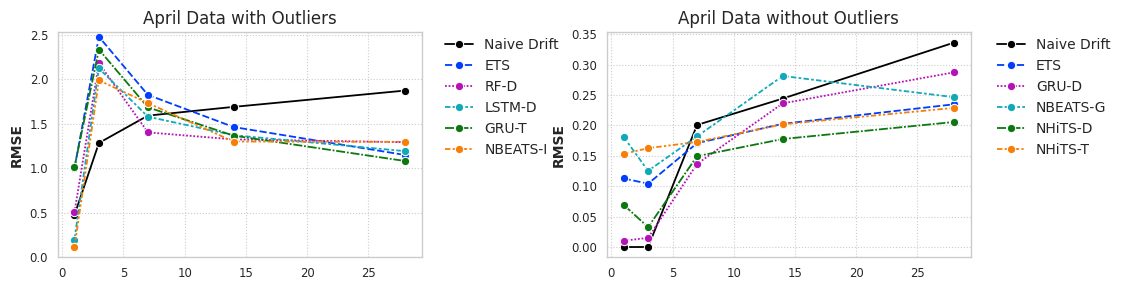

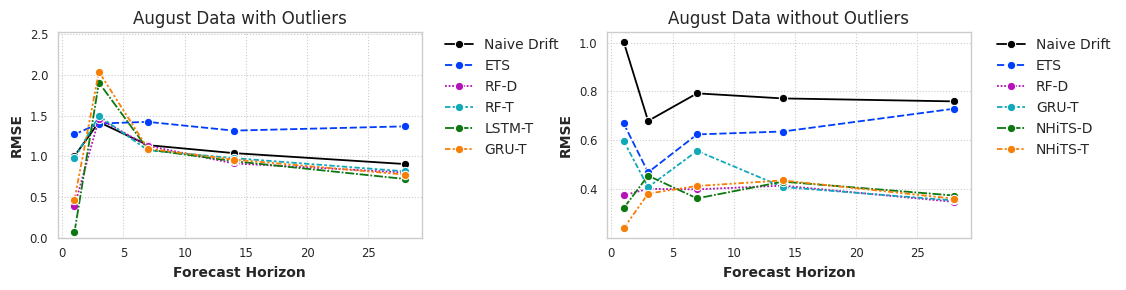

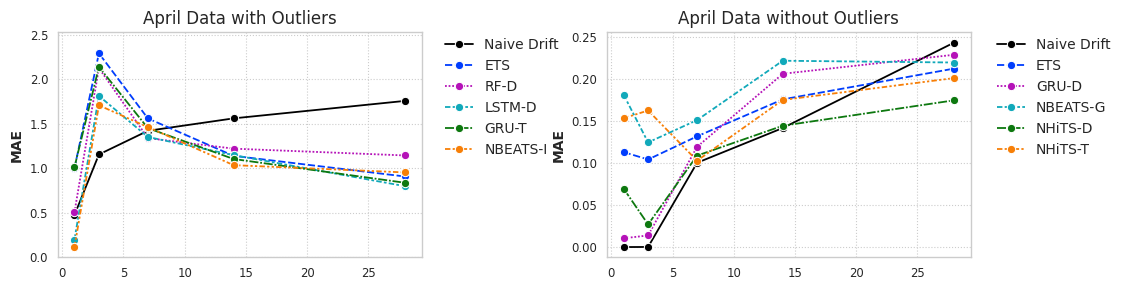

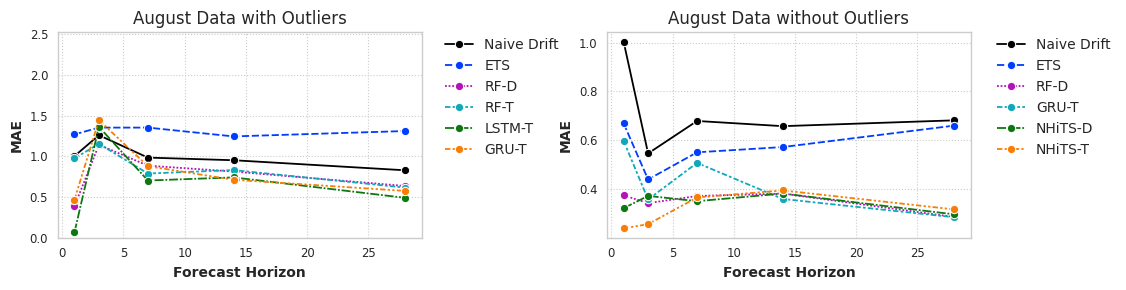

In [108]:
# Top Models

# April
top_rmse_outl_apr_outlCond = list(rmse_outl_apr_outlCond.sort_values(by='Median').reset_index().loc[:3,'model_name'])
top_rmse_clean_apr_outlCond = list(rmse_clean_apr_outlCond.sort_values(by='Median').reset_index().loc[:4,'model_name']) #ETS is already in top

top_mae_outl_apr_outlCond = list(mae_outl_apr_outlCond.sort_values(by='Median').reset_index().loc[:3,'model_name'])
top_mae_clean_apr_outlCond = list(mae_clean_apr_outlCond.sort_values(by='Median').reset_index().loc[:3,'model_name'])

# August
top_rmse_outl_aug_outlCond = list(rmse_outl_aug_outlCond.sort_values(by='Median').reset_index().loc[:3,'model_name'])
top_rmse_clean_aug_outlCond = list(rmse_clean_aug_outlCond.sort_values(by='Median').reset_index().loc[:3,'model_name'])

top_mae_outl_aug_outlCond = list(mae_outl_aug_outlCond.sort_values(by='Median').reset_index().loc[:3,'model_name'])
top_mae_clean_aug_outlCond = list(mae_clean_aug_outlCond.sort_values(by='Median').reset_index().loc[:3,'model_name'])

for best in [top_rmse_outl_apr_outlCond, top_rmse_clean_apr_outlCond, top_mae_outl_apr_outlCond, top_mae_clean_apr_outlCond,
             top_rmse_outl_aug_outlCond, top_rmse_clean_aug_outlCond, top_mae_outl_aug_outlCond, top_mae_clean_aug_outlCond]:
    best.extend(['Naive Drift', 'ETS'])



# Top Model Data

#April
best_rmse_o_apr = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(top_rmse_outl_apr_outlCond)) & (apr_data_outl_cond['has_outliers'] == True)]
best_mae_o_apr = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(top_mae_outl_apr_outlCond)) & (apr_data_outl_cond['has_outliers'] == True)]

best_rmse_cl_apr = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(top_rmse_clean_apr_outlCond)) & (apr_data_outl_cond['has_outliers'] == False)]
best_mae_cl_apr = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(top_mae_clean_apr_outlCond)) & (apr_data_outl_cond['has_outliers'] == False)]

# August
best_rmse_o_aug = aug_data_outl_cond[(aug_data_outl_cond['model_name'].isin(top_rmse_outl_aug_outlCond)) & (aug_data_outl_cond['has_outliers'] == True)]
best_mae_o_aug = aug_data_outl_cond[(aug_data_outl_cond['model_name'].isin(top_mae_outl_aug_outlCond)) & (aug_data_outl_cond['has_outliers'] == True)]

best_rmse_cl_aug = aug_data_outl_cond[(aug_data_outl_cond['model_name'].isin(top_rmse_clean_aug_outlCond)) & (aug_data_outl_cond['has_outliers'] == False)]
best_mae_cl_aug = aug_data_outl_cond[(aug_data_outl_cond['model_name'].isin(top_mae_clean_aug_outlCond)) & (aug_data_outl_cond['has_outliers'] == False)]


best_models_by_month = {'April': {'best_ro': best_rmse_o_apr,
                                'best_mo': best_mae_o_apr,
                                'best_rc': best_rmse_cl_apr,
                                'best_mc': best_mae_cl_apr,},

                        'August': {'best_ro': best_rmse_o_aug,
                                  'best_mo': best_mae_o_aug,
                                  'best_rc': best_rmse_cl_aug,
                                  'best_mc': best_mae_cl_aug}
                        }

for error_metric in [RMSE, MAE]:
    for month in best_models_by_month.keys():

        month_data = best_models_by_month[month]

        sns.set_style("whitegrid", {"grid.color": ".8", "grid.linestyle": ":"})
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        y_max1 = max(best_models_by_month['April']['best_ro']['rmse'].max(), best_models_by_month['August']['best_ro'][error_metric].max()) + .05
        y_max2 = max(best_models_by_month['April']['best_rc']['rmse'].max(), best_models_by_month['August']['best_rc'][error_metric].max()) + .05

        g1 = sns.lineplot(ax=axes[0], data=month_data['best_ro'], x='forecast_horizon', y=error_metric, hue='model_name',
                        style='model_name', marker='o')
        g1.set_title(f'{month} Data with Outliers')
        if month == 'April':
            g1.set_xlabel('')
        else:
            g1.set_xlabel('Forecast Horizon')
        g1.set_ylabel(error_metric.upper())
        g1.set_ylim(0, y_max1)
        g1.legend(loc='best', bbox_to_anchor=(1.05,1), borderaxespad=0)

        fig.tight_layout()

        g2 = sns.lineplot(ax=axes[1], data=month_data['best_rc'], x='forecast_horizon', y=error_metric, hue='model_name',
                        style='model_name', marker='o')
        g2.set_title(f'{month} Data without Outliers')
        g1.set_title(f'{month} Data with Outliers')
        if month == 'April':
            g2.set_xlabel('')
        else:
            g2.set_xlabel('Forecast Horizon')
        g2.set_ylabel(error_metric.upper())
        # g2.set_ylim(0, y_max2)
        g2.legend(loc='upper right', bbox_to_anchor=(1.4,1), borderaxespad=0)

    # fig.tight_layout()

#### HP-Clean Condition

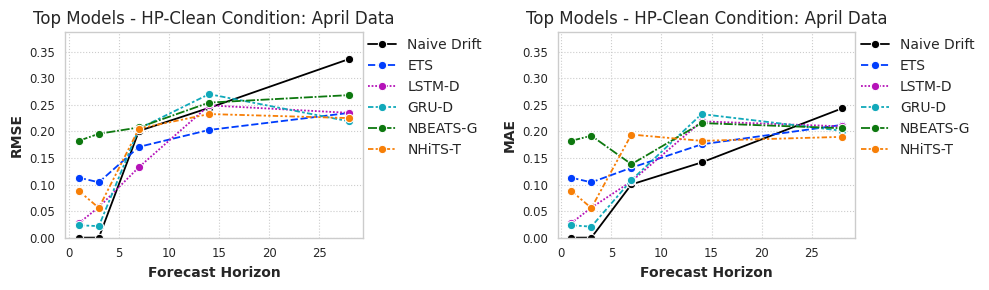

In [16]:
# Top Models

# April
top_rmse_clean_apr_clCond = list(rmse_clean_apr_clCond.sort_values(by='Median').reset_index().loc[:5,'model_name']) # extend to 5 -- top models include ETS & ND
top_mae_clean_apr_clCond = list(mae_clean_apr_clCond.sort_values(by='Median').reset_index().loc[:5,'model_name'])

# for best in [top_rmse_clean_apr_clCond, top_mae_clean_apr_clCond ]:
#     best.extend(['Naive Drift', 'ETS'])

# Top Model Data

month = 'April'

best_rmse_cl_apr = apr_data_cl_cond[(apr_data_cl_cond['model_name'].isin(top_rmse_clean_apr_clCond)) & (apr_data_cl_cond['has_outliers'] == False)]
best_mae_cl_apr = apr_data_cl_cond[(apr_data_cl_cond['model_name'].isin(top_mae_clean_apr_clCond)) & (apr_data_cl_cond['has_outliers'] == False)]

sns.set_style("whitegrid", {"grid.color": ".8", "grid.linestyle": ":"})
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
y_max1 = max(best_rmse_cl_apr['rmse'].max(), best_mae_cl_apr['mae'].max()) + .05
y_max2 = max(best_mae_cl_apr['rmse'].max(), best_mae_cl_apr['mae'].max()) + .05

g1 = sns.lineplot(ax=axes[0], data=best_rmse_cl_apr, x='forecast_horizon', y=RMSE, hue='model_name',
                style='model_name', marker='o')
g1.set_title(f'Top Models - HP-Clean Condition: {month} Data')
g1.set_xlabel('Forecast Horizon')
g1.set_ylabel(RMSE.upper())
g1.set_ylim(0, y_max1)
g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.lineplot(ax=axes[1], data=best_rmse_cl_apr, x='forecast_horizon', y=MAE, hue='model_name',
                style='model_name', marker='o')
g2.set_title(f'Top Models - HP-Clean Condition: {month} Data')
g2.set_xlabel('Forecast Horizon')
g2.set_ylabel(MAE.upper())
g2.set_ylim(0, y_max1)
g2.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

fig.tight_layout()




### **4. What is the performance differential for tuned vs. default model performance?**



#### April

### **Overall, how did the tuned models perform relative to the default models?**

####RMSE

In [104]:
error_metric = RMSE
apr = apr_data_outl_cond[~(apr_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
aug = aug_data_outl_cond[~(aug_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]

apr['model_name_proper'] = apr['model_name_proper'].replace('Random Forest', 'RF')
aug['model_name_proper'] = aug['model_name_proper'].replace('Random Forest', 'RF')

apr_diff_rmse = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

apr_diff_rmse['best_model'] = apr_diff_rmse.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)


aug_diff_rmse = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

aug_diff_rmse['best_model'] = aug_diff_rmse.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)




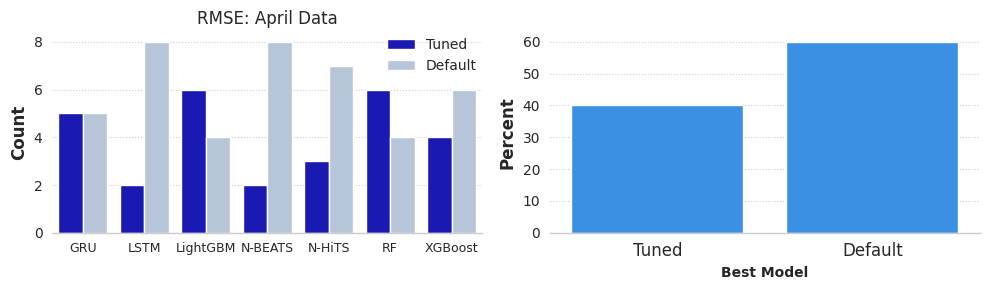

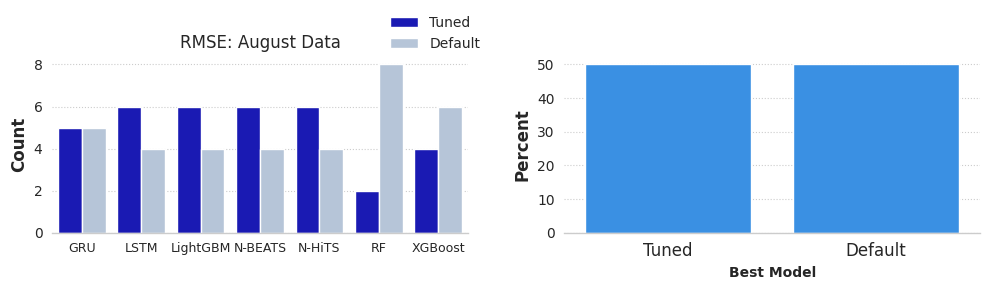

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
tick_fontsize = 15

g1 = sns.countplot(ax=axes[0], data=apr_diff_rmse, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'])
g1.set_title('RMSE: April Data')
g1.set_xlabel('')
g1.tick_params(axis='x', which='major', labelsize=9)
g1.set_ylabel('Count', fontsize=12)
g1.tick_params(axis='y', which='major', labelsize=10)

g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.countplot(ax=axes[1], data=apr_diff_rmse, x='best_model', color='dodgerblue', stat='percent')
g2.set_xlabel('Best Model')
g2.set_ylabel('Percent', fontsize=12)
g2.tick_params(axis='x', which='major', labelsize=12)
g2.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

fig.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
g3 = sns.countplot(ax=axes[0], data=aug_diff_rmse, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'], hue_order=['Tuned', 'Default'])
g3.set_title('RMSE: August Data')
g3.set_xlabel('')
g3.tick_params(axis='x', which='major', labelsize=9)
g3.set_ylabel('Count', fontsize=12)
g3.tick_params(axis='y', which='major', labelsize=10)
g3.legend(loc='best', bbox_to_anchor=(0.8,1), borderaxespad=0)

g4 = sns.countplot(ax=axes[1], data=aug_diff_rmse, x='best_model', color='dodgerblue', stat='percent',
                  order=['Tuned', 'Default'])
g4.set_xlabel('Best Model')
g4.set_ylabel('Percent', fontsize=12)
g4.tick_params(axis='x', which='major', labelsize=12)
g4.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

for direction in ['top', 'right', 'left']:
    g1.spines[direction].set_visible(False)
    g2.spines[direction].set_visible(False)
    g3.spines[direction].set_visible(False)
    g4.spines[direction].set_visible(False)

fig.show()



#### MAE

In [34]:
error_metric = 'mae'

apr_diff_mae = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

apr_diff_mae['best_model'] = apr_diff_mae.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)

aug_diff_mae = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

aug_diff_mae['best_model'] = aug_diff_mae.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)


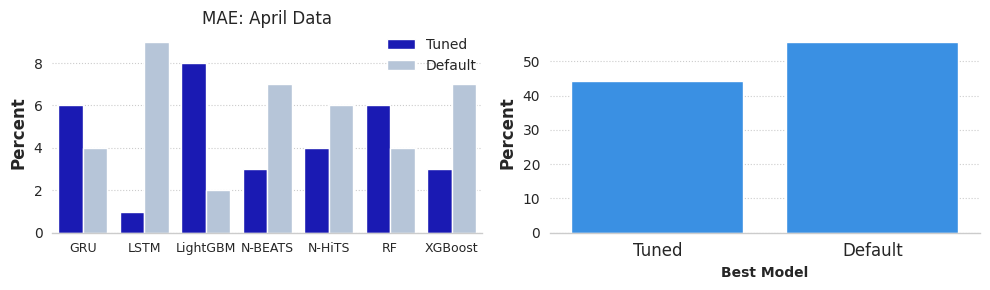

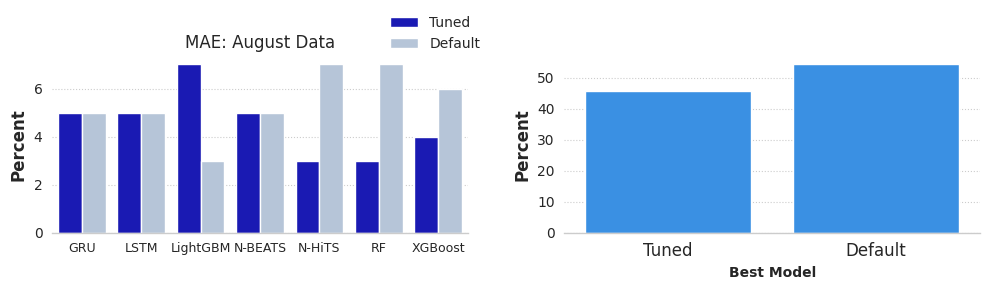

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
tick_fontsize = 15

g1 = sns.countplot(ax=axes[0], data=apr_diff_mae, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'])
g1.set_title('MAE: April Data')

g1.set_xlabel('')
g1.tick_params(axis='x', which='major', labelsize=9)
g1.set_ylabel('Percent', fontsize=12)
g1.tick_params(axis='y', which='major', labelsize=10)

g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.countplot(ax=axes[1], data=apr_diff_mae, x='best_model', color='dodgerblue', stat='percent')
g2.set_xlabel('Best Model')
g2.set_ylabel('Percent', fontsize=12)
g2.tick_params(axis='x', which='major', labelsize=12)
g2.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

fig.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
g3 = sns.countplot(ax=axes[0], data=aug_diff_mae, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'], hue_order=['Tuned', 'Default'])
g3.set_title('MAE: August Data')
g3.set_xlabel('')
g3.tick_params(axis='x', which='major', labelsize=9)
g3.set_ylabel('Percent', fontsize=12)
g3.tick_params(axis='y', which='major', labelsize=10)
g3.legend(loc='best', bbox_to_anchor=(0.8,1), borderaxespad=0)

g4 = sns.countplot(ax=axes[1], data=aug_diff_mae, x='best_model', color='dodgerblue', stat='percent',
                  order=['Tuned', 'Default'])
g4.set_xlabel('Best Model')
g4.set_ylabel('Percent', fontsize=12)
g4.tick_params(axis='x', which='major', labelsize=12)
g4.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

for direction in ['top', 'right', 'left']:
    g1.spines[direction].set_visible(False)
    g2.spines[direction].set_visible(False)
    g3.spines[direction].set_visible(False)
    g4.spines[direction].set_visible(False)

fig.show()


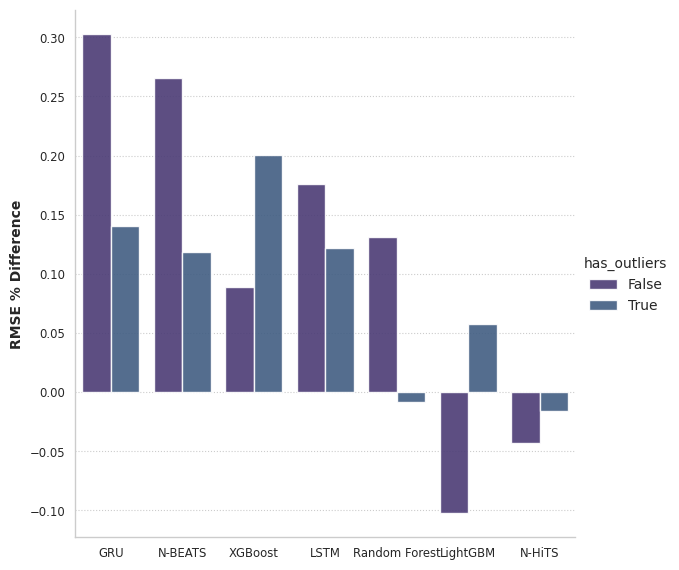

In [99]:
# Global

best_models_df2
data = best_models_df2[~(best_models_df2['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
rmse_diff = data[['FH', 'model_name_proper', 'has_outliers', 'model_type', RMSE]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=RMSE, aggfunc='mean')\
                    .reset_index()

rmse_diff['rmse_diff'] = rmse_diff['tuned'] - rmse_diff['default']
rmse_diff['rmse_percent_diff'] = (rmse_diff['tuned'] - rmse_diff['default']) / rmse_diff['default']
rmse_diff.reset_index(drop=True)
rmse_diff.sort_values(by='rmse_percent_diff', ascending=False, inplace=True)

tick_fontsize = 15
palette = sns.color_palette('viridis')
g = sns.catplot(
    data=rmse_diff, kind="bar",
    x="model_name_proper", y="rmse_percent_diff", hue="has_outliers", height=6, palette=palette, alpha=.9)
g.set_xlabels('')
g.set_ylabels('RMSE % Difference')
fig.tight_layout()

In [98]:
rmse_diff.sort_values(by='rmse_percent_diff', ascending=False)

model_type,model_name_proper,has_outliers,default,tuned,rmse_diff,rmse_percent_diff
0,GRU,False,0.233767,0.304653,0.070887,0.303237
6,N-BEATS,False,0.292687,0.370520,0.077833,0.265927
13,XGBoost,True,1.206100,1.448220,0.242120,0.200746
2,LSTM,False,0.240107,0.282413,0.042307,0.176199
1,GRU,True,1.124010,1.281550,0.157540,0.140159
10,Random Forest,False,0.257907,0.291813,0.033907,0.131469
3,LSTM,True,1.128890,1.266570,0.137680,0.121961
7,N-BEATS,True,1.192350,1.333830,0.141480,0.118656
12,XGBoost,False,0.284860,0.310207,0.025347,0.088979
5,LightGBM,True,1.109830,1.173240,0.063410,0.057135


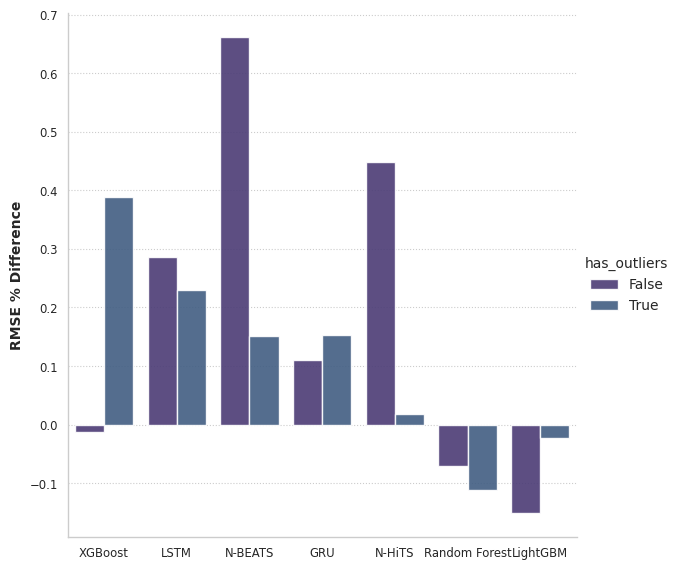

In [87]:
# RMSE
apr = apr_data_outl_cond[~(apr_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
apr_rmse_diff = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', RMSE]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=RMSE, aggfunc='mean')\
                    .reset_index()

apr_rmse_diff['rmse_diff'] = apr_rmse_diff['tuned'] - apr_rmse_diff['default']
apr_rmse_diff['rmse_percent_diff'] = (apr_rmse_diff['tuned'] - apr_rmse_diff['default']) / apr_rmse_diff['default']
apr_rmse_diff.reset_index(drop=True)
apr_rmse_diff.sort_values(by='rmse_diff', ascending=False, inplace=True)

tick_fontsize = 15
palette = sns.color_palette('viridis')
g = sns.catplot(
    data=apr_rmse_diff, kind="bar",
    x="model_name_proper", y="rmse_percent_diff", hue="has_outliers", height=6, palette=palette, alpha=.9)
g.set_xlabels('')
g.set_ylabels('RMSE % Difference')
fig.tight_layout()

In [103]:
apr_rmse_diff.head()

model_type,model_name_proper,has_outliers,default,tuned,rmse_diff,rmse_percent_diff
13,XGBoost,True,1.19482,1.65940,0.46458,0.388828
3,LSTM,True,1.29238,1.58840,0.29602,0.229050
7,N-BEATS,True,1.33615,1.53798,0.20183,0.151053
1,GRU,True,1.29700,1.49498,0.19798,0.152645
6,N-BEATS,False,0.21712,0.36074,0.14362,0.661478


In [19]:
print(f"On average, the tuned models' mean RMSE across all 5 forecast horizons is {apr_rmse_diff['rmse_diff'].mean():+.3f} vs. the default models' RMSE.")
print(f"There is a median difference of {apr_rmse_diff['rmse_diff'].median():+.3f} between the tuned models' mean RMSE vs. the default models'.\n")

print(f"There is a mean percentage difference of {apr_rmse_diff['rmse_percent_diff'].mean():+.1%} between the tuned and default versions of the models.")
print(f"There is a median percentage difference of {apr_rmse_diff['rmse_percent_diff'].median():+.1%} between the tuned and default versions of the models.")


On average, the tuned models' mean RMSE across all 5 forecast horizons is +0.087 vs. the default models' RMSE.
There is a median difference of +0.034 between the tuned models' mean RMSE vs. the default models'.

There is a mean percentage difference of +14.8% between the tuned and default versions of the models.
There is a median percentage difference of +13.0% between the tuned and default versions of the models.


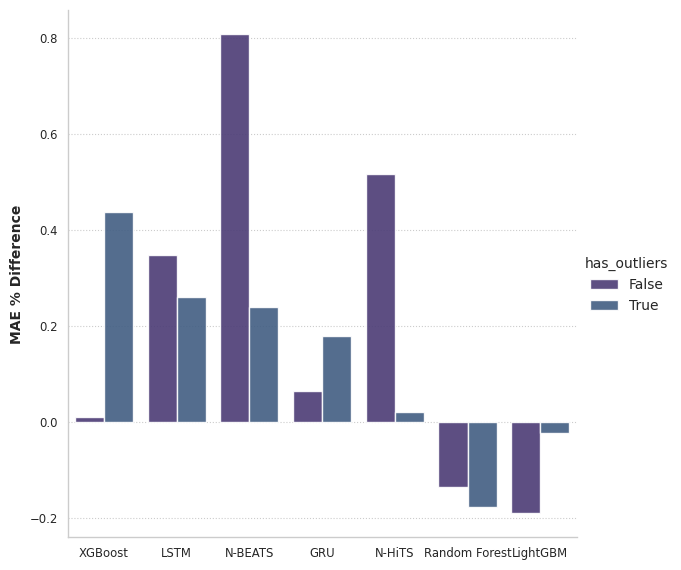

In [89]:
# MAE
apr = apr_data_outl_cond[~(apr_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
apr_mae_diff = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', MAE]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=MAE, aggfunc='mean')\
                    .reset_index()

apr_mae_diff['mae_diff'] = apr_mae_diff['tuned'] - apr_mae_diff['default']
apr_mae_diff['mae_percent_diff'] = (apr_mae_diff['tuned'] - apr_mae_diff['default']) / apr_mae_diff['default']
apr_mae_diff.reset_index(drop=True)
apr_mae_diff.sort_values(by='mae_diff', ascending=False, inplace=True)

palette = sns.color_palette('viridis')
g = sns.catplot(
    data=apr_mae_diff, kind="bar",
    x="model_name_proper", y="mae_percent_diff", hue="has_outliers", height=6, palette=palette, alpha=.9)
g.set_xlabels('')
g.set_ylabels('MAE % Difference')
fig.tight_layout()

In [90]:
display(apr_mae_diff)

model_type,model_name_proper,has_outliers,default,tuned,mae_diff,mae_percent_diff
13,XGBoost,True,1.01188,1.45464,0.44276,0.437562
3,LSTM,True,1.06150,1.33650,0.27500,0.259067
7,N-BEATS,True,1.07866,1.33624,0.25758,0.238796
1,GRU,True,1.10978,1.30786,0.19808,0.178486
6,N-BEATS,False,0.18123,0.32776,0.14653,0.808531
8,N-HiTS,False,0.10476,0.15874,0.05398,0.515273
2,LSTM,False,0.13068,0.17618,0.04550,0.348179
9,N-HiTS,True,1.23652,1.26090,0.02438,0.019717
0,GRU,False,0.11558,0.12306,0.00748,0.064717
12,XGBoost,False,0.18832,0.19010,0.00178,0.009452


In [21]:
print(f"On average, the tuned models' mean {MAE} across all 5 forecast horizons is {apr_mae_diff['mae_diff'].mean():+.3f} vs. the default models' {MAE}.")
print(f"There is a median difference of {apr_mae_diff['mae_diff'].median():+.3f} between the tuned models' mean {MAE} vs. the default models'.\n")

print(f"There is a mean percentage difference of {apr_mae_diff['mae_percent_diff'].mean():+.1%} between the tuned and default versions of the models.")
print(f"There is a median percentage difference of {apr_mae_diff['mae_percent_diff'].median():+.1%} between the tuned and default versions of the models.")


On average, the tuned models' mean mae across all 5 forecast horizons is +0.082 vs. the default models' mae.
There is a median difference of +0.035 between the tuned models' mean mae vs. the default models'.

There is a mean percentage difference of +16.8% between the tuned and default versions of the models.
There is a median percentage difference of +12.2% between the tuned and default versions of the models.


#### August

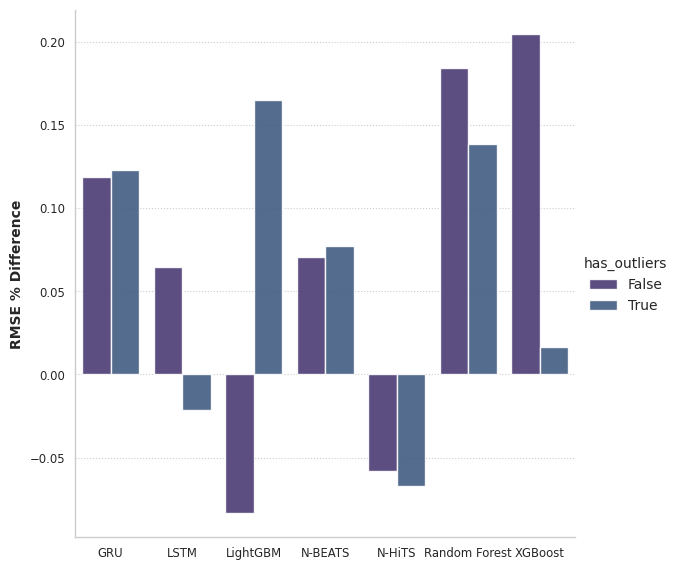

In [74]:
error_metric =  RMSE
aug = aug_data_outl_cond[~(aug_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
aug_rmse_diff = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=error_metric, aggfunc='mean')\
                    .reset_index()

aug_rmse_diff[f'rmse_diff'] = aug_rmse_diff['tuned'] - aug_rmse_diff['default']
aug_rmse_diff[f'rmse_percent_diff'] = (aug_rmse_diff['tuned'] - aug_rmse_diff['default']) / aug_rmse_diff['default']
aug_rmse_diff.sort_values(by=f'rmse_diff', ascending=False).reset_index(drop=True)


# display(aug_rmse_diff)


tick_fontsize = 15
palette = sns.color_palette('viridis')
g = sns.catplot(
    data=aug_rmse_diff, kind="bar",
    x="model_name_proper", y="rmse_percent_diff", hue="has_outliers", height=6, palette=palette, alpha=.9) # palette="dark",  , palette='cubehelix'
g.set_xlabels('')
g.set_ylabels('RMSE % Difference')


fig.tight_layout()

In [23]:
print(f"On average, the tuned models' mean RMSE across all 5 forecast horizons is {aug_rmse_diff['rmse_diff'].mean():+.3f} vs. the default models' RMSE.")
print(f"There is a median difference of {aug_rmse_diff['rmse_diff'].median():+.3f} between the tuned models' mean RMSE vs. the default models'.\n")

print(f"There is a mean percentage difference of {aug_rmse_diff['rmse_percent_diff'].mean():+.1%} between the tuned and default versions of the models.")
print(f"There is a median percentage difference of {aug_rmse_diff['rmse_percent_diff'].median():+.1%} between the tuned and default versions of the models.")


On average, the tuned models' mean RMSE across all 5 forecast horizons is +0.045 vs. the default models' RMSE.
There is a median difference of +0.039 between the tuned models' mean RMSE vs. the default models'.

There is a mean percentage difference of +6.7% between the tuned and default versions of the models.
There is a median percentage difference of +7.4% between the tuned and default versions of the models.


In [24]:
error_metric =  MAE
aug_mae_diff = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=error_metric, aggfunc='mean')\
                    .reset_index()

aug_mae_diff['mae_diff'] = aug_mae_diff['tuned'] - aug_mae_diff['default']
aug_mae_diff['mae_percent_diff'] = (aug_mae_diff['tuned'] - aug_mae_diff['default']) / aug_mae_diff['default']
aug_mae_diff.sort_values(by=f'{error_metric}_diff', ascending=False).reset_index(drop=True)

model_type,model_name_proper,has_outliers,default,tuned,mae_diff,mae_percent_diff
0,N-BEATS,True,0.74114,0.90872,0.16758,0.226111
1,XGBoost,False,0.38500,0.48862,0.10362,0.269143
2,Random Forest,True,0.77320,0.87386,0.10066,0.130186
3,LightGBM,True,0.76732,0.86110,0.09378,0.122218
4,Random Forest,False,0.35230,0.42894,0.07664,0.217542
5,GRU,True,0.75986,0.81632,0.05646,0.074303
6,XGBoost,True,0.98294,1.03362,0.05068,0.051560
7,GRU,False,0.38064,0.42232,0.04168,0.109500
8,N-BEATS,False,0.36307,0.39180,0.02873,0.079131
9,LSTM,False,0.37924,0.40096,0.02172,0.057272


In [25]:
print(f"On average, the tuned models' mean {error_metric.upper()} across all 5 forecast horizons is {aug_mae_diff['mae_diff'].mean():+.3f} vs. the default models' {error_metric.upper()}.")
print(f"There is a median difference of {aug_mae_diff['mae_diff'].median():+.3f} between the tuned models' mean {MAE.upper()} vs. the default models'.\n")

print(f"There is a mean percentage difference of {aug_mae_diff['mae_percent_diff'].mean():+.1%} between the tuned and default versions of the models.")
print(f"There is a median percentage difference of {aug_mae_diff['mae_percent_diff'].median():+.1%} between the tuned and default versions of the models.")


On average, the tuned models' mean MAE across all 5 forecast horizons is +0.047 vs. the default models' MAE.
There is a median difference of +0.046 between the tuned models' mean MAE vs. the default models'.

There is a mean percentage difference of +8.2% between the tuned and default versions of the models.
There is a median percentage difference of +7.7% between the tuned and default versions of the models.


### **5. What was the difference in tuned model performance for clean data for the Hyperparameter Clean vs. Hyperparameter Outlier Conditions?**

#### April: Outlier Condition vs. Clean Condition

In [26]:
apr_cl = apr_data_cl_cond[~(apr_data_cl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
apr_cl = apr_cl[['FH','model_name_proper', 'model_name_fh', 'has_outliers', 'model_type', RMSE]]\
                    .pivot_table(index=['FH','model_name_proper', 'model_name_fh', 'has_outliers'], columns='model_type', values=RMSE)\
                    .reset_index().loc[:, ['FH','model_name_proper', 'tuned']]
apr_cl['unique_id'] = apr_cl['model_name_proper'] + '-' +  apr_cl['FH']
apr_cl.rename(columns={'tuned':'clean_cond_tuned'}, inplace=True)

apr_outl = apr_data_outl_cond[~(apr_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift'])) &  ~ (apr_data_outl_cond['model_type'] == 'default') &  (apr_data_outl_cond['has_outliers'] == False)]
apr_outl = apr_outl[['FH','model_name_proper', 'model_name_fh', 'has_outliers', 'model_type', RMSE]]\
                    .pivot_table(index=['FH','model_name_proper', 'model_name_fh', 'has_outliers'], columns='model_type', values=RMSE)\
                    .reset_index().loc[:, ['FH','model_name_proper', 'tuned']]
apr_outl['unique_id'] = apr_outl['model_name_proper'] + '-' +  apr_outl['FH']
apr_outl.rename(columns={'tuned':'outlier_cond_tuned'}, inplace=True)

apr_tuned_comparison = apr_cl.merge(apr_outl[['unique_id', 'outlier_cond_tuned']], on=['unique_id'], how='inner').reset_index()
reordered_cols = ['unique_id', 'model_name_proper', 'FH', 'clean_cond_tuned', 'outlier_cond_tuned']
apr_tuned_comparison = apr_tuned_comparison[reordered_cols]

apr_tuned_comparison['diff'] = apr_tuned_comparison['clean_cond_tuned'] - apr_tuned_comparison['outlier_cond_tuned']
apr_tuned_comparison = apr_tuned_comparison.sort_values(by=['model_name_proper', 'diff'], ascending=[True, False])
apr_tuned_comparison.head()

model_type,unique_id,model_name_proper,FH,clean_cond_tuned,outlier_cond_tuned,diff
46,GRU-FH-3,GRU,FH-3,0.6422,0.1281,0.5141
1,GRU-FH-1,GRU,FH-1,0.1797,0.0048,0.1749
31,GRU-FH-28,GRU,FH-28,0.2507,0.2280,0.0227
16,GRU-FH-14,GRU,FH-14,0.2305,0.2172,0.0133
61,GRU-FH-7,GRU,FH-7,0.1770,0.1831,-0.0061


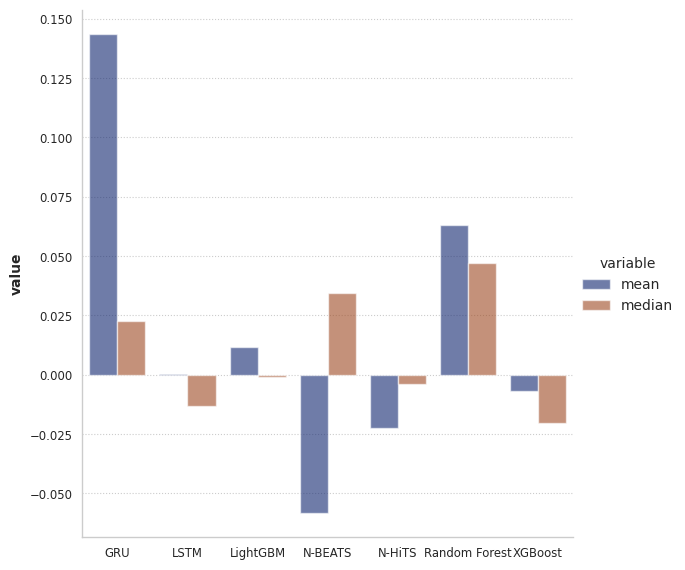

In [27]:
apr_diff = apr_tuned_comparison[['model_name_proper', 'diff']].groupby(by=['model_name_proper'])\
                                                   .agg(median = ('diff','median'), mean= ('diff','mean')).reset_index()

apr_diff = pd.melt(apr_diff, id_vars=['model_name_proper'], value_vars=['mean', 'median'])

tick_fontsize = 15
g = sns.catplot(
    data=apr_diff, kind="bar",
    x="model_name_proper", y="value", hue="variable",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.set_xlabels('')



### Was N-Hits Significantly more efficient than N-Beats?

In [28]:
n_deep_models = apr_data_outl_cond[(apr_data_outl_cond['model_name_proper'].isin(['N-BEATS', 'N-HiTS']))].loc[:,['forecast_horizon','model_name', 'training_time', 'rmse']]
n_deep_models.head(3)

,forecast_horizon,model_name,training_time,rmse
120,1,NBEATS-G,29.786,0.0761
121,3,NBEATS-G,29.717,2.1794
122,7,NBEATS-G,30.052,1.8087


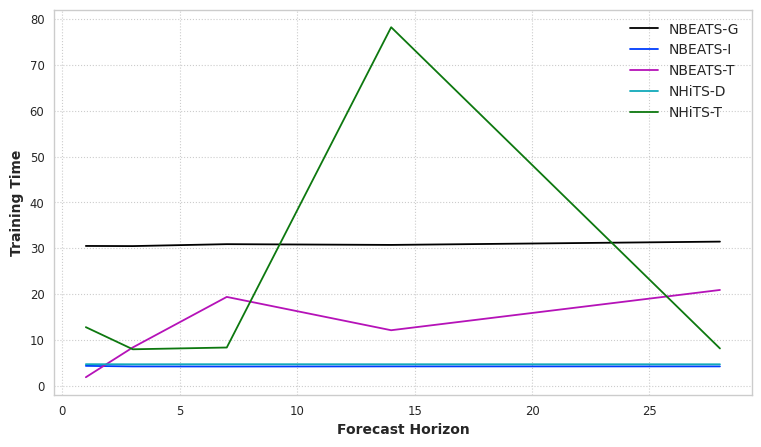

In [29]:
avg_rmse = n_deep_models.groupby(by=['model_name', 'forecast_horizon']).mean().reset_index()

fig, ax = plt.subplots(figsize=(9, 5))
g = sns.lineplot(data=avg_rmse, x='forecast_horizon', y='training_time', hue='model_name')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))
g.set_xlabel('Forecast Horizon')
g.set_ylabel('Training Time')
g.legend(title='')

fig.show()

In [30]:
median_rmse = n_deep_models.groupby(by=['model_name']).median().reset_index()


median_rmse = median_rmse.sort_values(by='rmse', ascending=True)

# import plotly.graph_objs as go
# from plotly.subplots import make_subplots


# fig, ax = plt.subplots(figsize=(10, 5))
vf.dual_bar_chart(df=median_rmse, x='model_name', y1='rmse', y2='training_time',
                y1_label='RMSE', y2_label='Training Time',y1_color='purple', y2_color='skyblue',
                font_size=14, align_axes=True, name='median_rmse_vs_training_nbeats_nhits')

In [31]:
nbg_train_time = median_rmse.loc[median_rmse['model_name'] == 'NBEATS-G', 'training_time'][0]
nbg_rmse = median_rmse.loc[median_rmse['model_name'] == 'NBEATS-G', RMSE][0]

print('The default generic version of N-BEATS took:\n')
for model_name in [name for name in median_rmse['model_name'].unique() if name != 'NBEATS-G']:
    comp_train_time = float(median_rmse.loc[median_rmse['model_name'] == model_name, 'training_time'])
    comp_rmse = float(median_rmse.loc[median_rmse['model_name'] == model_name, RMSE])

    diff = nbg_train_time / comp_train_time
    rmse_diff = (nbg_rmse - comp_rmse) / comp_rmse
    print(f'{diff:.1f}X as long to train as {model_name} and had an RMSE of {rmse_diff:+.1%} relative to the latter.')

# median_rmse.loc[median_rmse['model_name'] == name, 'training_time']

The default generic version of N-BEATS took:

6.6X as long to train as NHiTS-D and had an RMSE of +15.4% relative to the latter.
7.3X as long to train as NBEATS-I and had an RMSE of -7.2% relative to the latter.
2.9X as long to train as NHiTS-T and had an RMSE of -25.5% relative to the latter.
2.5X as long to train as NBEATS-T and had an RMSE of -58.9% relative to the latter.


In [37]:
print(f'\n\n------------------ LATEX TABLES FOR REPORT ------------------\n')

print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: April RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: April RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: April MAE ------------------\n')
_ = pf.highlight_min_max(df=mae_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: August MAE ------------------\n')
_ = pf.highlight_min_max(df=mae_clean_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)



print(f'\n\n------------------ REMAINING TABLES FOR APPENDICES ------------------\n')


print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: April MAE ------------------\n')
_ = pf.highlight_min_max(df=mae_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: August RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: August MAE ------------------\n')
_ = pf.highlight_min_max(df=mae_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: August  RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_clean_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {clean_condition} Condition - Clean Dataset: April RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {clean_condition} Condition - Clean Dataset: April MAE ------------------\n')
_ = pf.highlight_min_max(df=mae_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)




------------------ LATEX TABLES FOR REPORT ------------------



------------------ Hyperparam-Outlier Condition - Outlier Dataset: April RMSE ------------------

Latex Version: 

\begin{tabular}{lrrrrrrr}
FH & FH-1 & FH-3 & FH-7 & FH-14 & FH-28 & Median & Mean \\
model_name &  &  &  &  &  &  &  \\
NBEATS-I & 0.112 & 1.987 & 1.731 & \bfseries \color{darkgreen} 1.300 & 1.296 & \bfseries \color{darkgreen} 1.300 & 1.288 \\
RF-D & 0.504 & 2.180 & \bfseries \color{darkgreen} 1.403 & 1.324 & 1.292 & 1.324 & 1.338 \\
GRU-T & 1.010 & 2.333 & 1.684 & 1.366 & \bfseries \color{darkgreen} 1.081 & 1.366 & 1.474 \\
LSTM-D & 0.198 & 2.122 & 1.579 & 1.371 & 1.192 & 1.371 & 1.306 \\
RF-T & \bfseries \color{darkgreen} 0.014 & 1.872 & 1.547 & 1.375 & 1.150 & 1.375 & \bfseries \color{darkgreen} 1.222 \\
GRU-D & 0.176 & 2.236 & 1.546 & 1.378 & 1.148 & 1.378 & 1.310 \\
LGBM-D & 0.248 & 1.847 & 1.637 & 1.391 & 1.246 & 1.391 & 1.293 \\
XGB-D & 0.092 & 1.454 & 1.697 & 1.510 & 1.220 & 1.454 & 1.238 \\
LGBM-T 

In [9]:
# convert to pdf and/or html
!jupyter nbconvert --to pdf  '/content/gdrive/MyDrive/Colab Notebooks/sunshine_duration_forecasting.ipynb'
!jupyter nbconvert --to html  '/content/gdrive/MyDrive/Colab Notebooks/sunshine_duration_forecasting.ipynb'

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/sunshine_duration_forecasting.ipynb to pdf
/usr/local/share/jupyter/nbconvert/templates/latex/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  ((*- endblock -*))
[NbConvertApp] Support files will be in sunshine_duration_forecasting_files/
[NbConvertApp] Making directory ./sunshine_duration_forecasting_files
[NbConvertApp] Writing 383510 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2035669 bytes to /content/gdrive/MyDrive/Colab Notebooks/sunshine_duration_forecasting.pdf
[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/su